### Parts of this assignment will be **automatically graded**. Please take note of the following:
- Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).
- You can add additional cells, but it is not recommended to (re)move cells. Cells required for autograding cannot be moved and cells containing tests cannot be edited.
- You are allowed to use a service such as [Google Colaboratory](https://colab.research.google.com/) to work together. However, you **cannot** hand in the notebook that was hosted on Google Colaboratory, but you need to copy your answers into the original notebook and verify that it runs succesfully offline. This is because Google Colaboratory destroys the metadata required for grading.
- Name your notebook **exactly** `{TA_name}_{student1_id}_{student2_id}_lab{i}.ipynb`, for example `wouter_12345_67890_lab1.ipynb` (or tim|elise|david|qi, depending on your TA), **otherwise your submission will be skipped by our regex and you will get 0 points** (but no penalty as we cannot parse your student ids ;)).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your names below:

In [1]:
NAMES = "Philipp Lintl, Bogdan Floris"

---

In [2]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
import sys

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm as _tqdm

import random
import time
from collections import defaultdict

def tqdm(*args, **kwargs):
    return _tqdm(*args, **kwargs, mininterval=1)  # Safety, do not overflow buffer

EPS = float(np.finfo(np.float32).eps)

assert sys.version_info[:3] >= (3, 6, 0), "Make sure you have Python 3.6 installed!"

## 1. Temporal Difference (TD) learning (8 points)
Mention one advantage and one disadvantage of Monte Carlo methods. Mention an example where you would prefer to use TD learning.

One advantage of Monte Carlo methods is that it does not require a full knowledge of the environment (MDP), but the disadvatange is that it does not learn until the episode ends (and thus only works for episodic tasks). TD learning is prefered when the task is not episodic (we do not need to store sample trajectories) and the model is unknown.

For the TD algorithms, we will skip the prediction algorithm and go straight for the control setting where we optimize the policy that we are using. In other words: implement SARSA. To keep it dynamic, we will use the windy gridworld environment (Example 6.5).

In [3]:
from windy_gridworld import WindyGridworldEnv
env = WindyGridworldEnv()

In [4]:
import itertools

def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    """
    def policy_fn(observation):
        return int(np.random.rand() * nA) if np.random.rand() < epsilon else np.argmax(Q[observation])
    return policy_fn

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1251.28it/s]


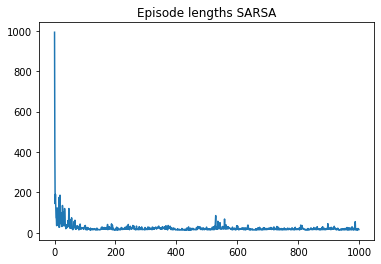

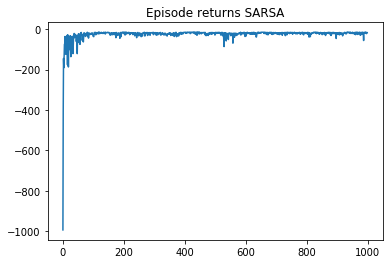

In [5]:
def sarsa(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1, Q=None):
    """
    SARSA algorithm: On-policy TD control. Finds the optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Probability to sample a random action. Float between 0 and 1.
        Q: hot-start the algorithm with a Q value function (optional)
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is a list of tuples giving the episode lengths and rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    if Q is None:
        Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = []
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)

    for i_episode in tqdm(range(num_episodes)):
        episode_reward = 0
        # initialize state
        state = env.reset()
        # choose action from state based on the policy
        action = policy(state)
        # loop for each step in the episode
        for step in itertools.count():
            # take action and observe the next state, reward, and if we are done
            next_state, reward, done, _ = env.step(action)
            # choose an action from next_state using the policy
            next_action = policy(next_state)
            # update the total episode reward
            episode_reward += reward
            # sarsa Q update
            Q[state][action] += alpha * (reward + discount_factor * Q[next_state][next_action] - Q[state][action])
            # check for finished episode
            if done:
                break
            # otherwise update state and action
            state = next_state
            action = next_action
        
        stats.append((step, episode_reward))
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)

Q_sarsa, (episode_lengths_sarsa, episode_returns_sarsa) = sarsa(env, 1000)

# We will help you with plotting this time
plt.plot(episode_lengths_sarsa)
plt.title('Episode lengths SARSA')
plt.show()
plt.plot(episode_returns_sarsa)
plt.title('Episode returns SARSA')
plt.show()

We learn the optimal (non-exploring) policy while using another policy to do exploration, which is where we arrive at _off-policy_ learning. In the simplest variant, we learn our own value by bootstrapping based on the action value corresponding to the best action we could take, while the exploration policy actual follows the $\epsilon$-greedy strategy. This is known as Q-learning.

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2577.79it/s]


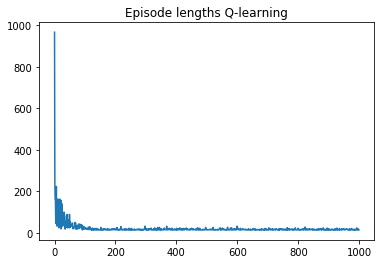

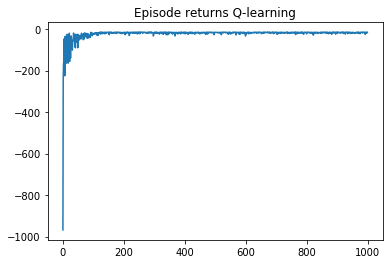

In [6]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1, Q=None):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: Gamma discount factor.
        alpha: TD learning rate.
        epsilon: Probability to sample a random action. Float between 0 and 1.
        Q: hot-start the algorithm with a Q value function (optional)
    
    Returns:
        A tuple (Q, stats).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is a list of tuples giving the episode lengths and rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    if Q is None:
        Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Keeps track of useful statistics
    stats = []
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    

    for i_episode in tqdm(range(num_episodes)):
        episode_reward = 0
        # initialize the state
        state = env.reset()
        # loop for each step in the episode
        for t in itertools.count():
            # choose action from state based on the policy
            action = policy(state)
            # take a step in the environment
            next_state, reward, done, _ = env.step(action)
            # update statistics
            episode_reward += reward
            # update Q
            best_next_action = np.argmax(Q[next_state])
            Q[state][action] += alpha * (reward + discount_factor *
                Q[next_state][best_next_action] - Q[state][action])
            # check for finished episode
            if done:
                break
            # otherwise update state
            state = next_state

        stats.append((t, episode_reward))
    episode_lengths, episode_returns = zip(*stats)
    return Q, (episode_lengths, episode_returns)

Q_q_learning, (episode_lengths_q_learning, episode_returns_q_learning) = q_learning(env, 1000)

# We will help you with plotting this time
plt.plot(episode_lengths_q_learning)
plt.title('Episode lengths Q-learning')
plt.show()
plt.plot(episode_returns_q_learning)
plt.title('Episode returns Q-learning')
plt.show()

Now compare the episode returns while learning for Q-learning and Sarsa (maybe run some more iterations?), by plotting the returns for both algorithms in a single plot, like in the book, Example 6.6. In order to be able to compare them, you may want to zoom in on the y-axis and smooth the returns (e.g. plotting the $n$ episode average instead).

In [7]:
def get_episode_rewards_average(algo, n=100):
    episode_rewards = np.zeros(1000)
    for i in range(n):
        _, (_, episode_returns) = algo(env, 1000)
        episode_rewards += episode_returns
    return episode_rewards / n

# Compute episode rewards for SARSA
episode_rewards_sarsa = get_episode_rewards_average(sarsa)
# COmpute episode rewards for Q-Learning
episode_rewards_q_learning = get_episode_rewards_average(q_learning)
    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 850.69it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2404.10it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1862.20it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2256.59it/s]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2449.62it/s]


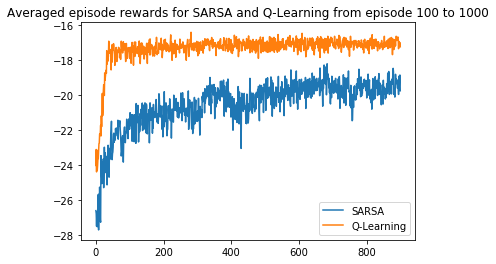

In [8]:
plt.plot(episode_rewards_sarsa[100:], label="SARSA")
plt.plot(episode_rewards_q_learning[100:], label="Q-Learning")
plt.title("Averaged episode rewards for SARSA and Q-Learning from episode 100 to 1000")
plt.legend()
plt.show()

Which algorithm achieves higher return during learning? How does this compare to Example 6.6 from the book? Try to explain your observations.

For the Windy Gridworld environment, Q-Learning achieves the higher returns during learning, which is opposed to the Cliff Walking environment. Since there is no risk in running of a cliff in this example, Q-Learning can learn the optiomal policy and progress through it even with an $\epsilon$-greedy policy.

After we have learned the policy, we do not care about exploration any more and we may switch to a deterministic (greedy) policy instead. If we evaluate this for both Sarsa and Q-learning (actually, for Q-learning the learned policy is already deterministic), which policy would you expect to perform better? Why?

Since Q-Learning seems to have learned the better policy, it should perform slightly better than SARSA even in a deterministic setting.

Please run the experiments to test your hypothesis (print or plot your results). How many runs do you need to evaluate the policy? Note: without learning, the order of the episodes is not relevant so a normal `plt.plot` may not be the most appropriate choice.

Since the policies are deterministic, we only need one run to determine the rewards for both algorithms.

In [9]:
# Get the deterministic policies
policy_sarsa = make_epsilon_greedy_policy(Q_sarsa, 0.0, env.action_space.n)
policy_q_learning= make_epsilon_greedy_policy(Q_q_learning, 0.0, env.action_space.n)

def get_rewards(env, policy, num_episodes=1):
    rewards = []
    for _ in tqdm(range(num_episodes)):
        episode_reward = 0
        # initialize the state
        state = env.reset()
        # loop for each step in the episode
        for t in itertools.count():
            # choose action from state based on the policy
            action = policy(state)
            # take a step in the environment
            next_state, reward, done, _ = env.step(action)
            # update statistics
            episode_reward += reward
            # check for finished episode
            if done:
                break
            # otherwise update state
            state = next_state
        rewards.append(episode_reward)
    
    return rewards

determ_rewards_sarsa = get_rewards(env, policy_sarsa)
determ_rewards_q_learning = get_rewards(env, policy_q_learning)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.14it/s]


In [10]:
print("Deterministic rewards SARSA: {}".format(np.mean(determ_rewards_sarsa)))
print("Deterministic rewards Q-Learning: {}".format(np.mean(determ_rewards_q_learning)))

Deterministic rewards SARSA: -17.0
Deterministic rewards Q-Learning: -15.0


---
## 2. Deep Q-Network (DQN) (10 points)

In [11]:
import gym
env = gym.envs.make("CartPole-v0")

C:\Users\lintl\Anaconda3\envs\rl2019\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [12]:
# env is a TimeLimit wrapper around an env, so use env.env to look into the env (but otherwise you can forget about this)
??env.env

In [13]:
import time
# The nice thing about the CARTPOLE is that it has very nice rendering functionality (if you are on a local environment). Let's have a look at an episode
obs = env.reset()
env.render()
done = False
while not done:
    obs, reward, done, _ = env.step(env.action_space.sample())
    env.render()
    time.sleep(0.05)
env.close()  # Close the environment or you will have a lot of render screens soon

Remember from the previous lab, that in order to optimize a policy we need to estimate the Q-values (e.g. estimate the *action* values). In the CartPole problem, our state is current position of the cart, the current velocity of the cart, the current (angular) position of the pole and the (angular) speed of the pole. As these are continuous variables, we have an infinite number of states (ignoring the fact that a digital computer can only represent finitely many states in finite memory).

Can you think of a way in which we can still use a tabular approach? Why would this work and can you think of an example problem where this would not work?

One way in which we can still use a tabular approach is to aggregate the values into bins. All the values that make up a state in CartPole have a minimum and a maximum. This approach fails for problems where we cannot determine a minimum or a maximum value and thus we cannot determine the ammount of bins to use for aggregation.

### 2.1 Implement Q-Network

We will not use the tabular approach but approximate the Q-value function by a general approximator function. We will skip the linear case and directly use a two layer Neural Network. We use [PyTorch](https://pytorch.org/) to implement the network, as this will allow us to train it easily later. We can implement a model using `torch.nn.Sequential`, but with PyTorch it is actually very easy to implement the model (e.g. the forward pass) from scratch. Now implement the `QNetwork.forward` function that uses one hidden layer with ReLU activation (no output activation).

In [14]:
class QNetwork(nn.Module):
    
    def __init__(self, num_hidden=128):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(4, num_hidden)
        self.l2 = nn.Linear(num_hidden, 2)

    def forward(self, x):
        return self.l2(torch.relu(self.l1(x)))

In [15]:
# Let's instantiate and test if it works
num_hidden = 128
torch.manual_seed(1234)
model = QNetwork(num_hidden)

torch.manual_seed(1234)
test_model = nn.Sequential(
    nn.Linear(4, num_hidden), 
    nn.ReLU(), 
    nn.Linear(num_hidden, 2)
)

x = torch.rand(10, 4)

# If you do not need backpropagation, wrap the computation in the torch.no_grad() context
# This saves time and memory, and PyTorch complaints when converting to numpy
with torch.no_grad():
    assert np.allclose(model(x).numpy(), test_model(x).numpy())

### 2.2 Experience Replay

What could be a problem with doing gradient updates on a sequence of state, action pairs $((s_t, a_t), (s_{t+1}, a_{t+1}) ...)$ observed while interacting with the environment? How will using *experience replay* help to overcome this (potential problem)?

Doing gradient updates on a sequence of state, action pairs clearly violates the independence assumption of the data. Since the states come in a sequence, they are very much dependent on each other. Experience replay helps overcome this problem by randomly sampling from a big pool of state, action pairs. The data is still dependent but clearly not as much.

Now implement the `push` function that adds a transition to the replay buffer, and the sample function that returns a batch of samples. It should keep at most the maximum number of transitions. Also implement the `sample` function that samples a (random!) batch of data, for use during training (hint: you can use the function `random.sample`).

In [16]:
import random

In [17]:
class ReplayMemory:
    
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition):
        if len(self.memory) == self.capacity:
            self.memory.pop(0)
        self.memory.append(transition)

    def sample(self, batch_size):
        if len(self.memory) < batch_size:
            raise ValueError('Not enough memory to sample batch.')
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [18]:
capacity = 10
memory = ReplayMemory(capacity)

# Sample a transition
s = env.reset()
a = env.action_space.sample()
s_next, r, done, _ = env.step(a)

# Push a transition
memory.push((s, a, r, s_next, done))

# Sample a batch size of 1
print(memory.sample(1))


[(array([ 0.00572155,  0.02683287, -0.01174029, -0.0230005 ]), 0, 1.0, array([ 0.00625821, -0.16811876, -0.0122003 ,  0.26595524]), False)]


### 2.3 $\epsilon$psilon greedy policy

In order to learn a good policy, we need to explore quite a bit initially. As we start to learn a good policy, we want to decrease the exploration. As the amount of exploration using an $\epsilon$-greedy policy is controlled by $\epsilon$, we can define an 'exploration scheme' by writing $\epsilon$ as a function of time. There are many possible schemes, but we will use a simple one: we will start with only exploring (so taking random actions) at iteration 0, and then in 1000 iterations linearly anneal $\epsilon$ such that after 1000 iterations we take random (exploration) actions with 5\% probability (forever, as you never know if the environment will change).

In [19]:
epsilons = np.linspace(1.0, 0.05, 1000)

def get_epsilon(it):
    if it >= 1000:
        return 0.05
    else:
        return epsilons[it]

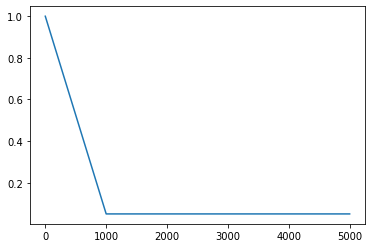

In [20]:
# So what's an easy way to check?
plt.plot([get_epsilon(it) for it in range(5000)])


Now write a function that takes a state and uses the Q-network to select an ($\epsilon$-greedy) action. It should return a random action with probability epsilon (which we will pass later). Note, you do not need to backpropagate through the model computations, so use `with torch.no_grad():` (see above for example). Unlike numpy, PyTorch has no argmax function, but Google is your friend... Note that to convert a PyTorch tensor with only 1 element (0 dimensional) to a simple python scalar (int or float), you can use the '.item()' function.

In [21]:
def select_action(model, state, epsilon):
    if np.random.rand() < epsilon:
        return int(np.random.rand() * 2)
    else:
        with torch.no_grad():
            output = model(torch.Tensor(state))
            return torch.argmax(output).item()
        

In [22]:
s = env.reset()
a = select_action(model, s, 0.05)
assert not torch.is_tensor(a)
print (a)


1


### 2.4 Training function

Now we will implement the function 'train' that samples a batch from the memory and performs a gradient step using some convenient PyTorch functionality. However, you still need to compute the Q-values for the (state, action) pairs in the experience, as well as their target (e.g. the value they should move towards). What is the target for a Q-learning update? What should be the target if `next_state` is terminal (e.g. `done`)?

For computing the Q-values for the actions, note that the model returns all action values where you are only interested in a single action value. Because of the batch dimension, you can't use simple indexing, but you may want to have a look at [torch.gather](https://pytorch.org/docs/stable/torch.html?highlight=gather#torch.gather) or use [advanced indexing](https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.indexing.html) (numpy tutorial but works mostly the same in PyTorch). Note, you should NOT modify the function train. You can view the size of a tensor `x` with `x.size()` (similar to `x.shape` in numpy).

In [23]:
def compute_q_val(model, state, action):
    q_val = model(state)
    return q_val[np.arange(action.size()[0]), action]
    
def compute_target(model, reward, next_state, done, discount_factor):
    # done is a boolean (vector) that indicates if next_state is terminal (episode is done)
    q_val_next = model(next_state)
    targets = reward + discount_factor * (1 - done).float() * torch.max(q_val_next, dim=1)[0]
    return targets

def train(model, memory, optimizer, batch_size, discount_factor):
    # DO NOT MODIFY THIS FUNCTION
    
    # don't learn without some decent experience
    if len(memory) < batch_size:
        return None

    # random transition batch is taken from experience replay memory
    transitions = memory.sample(batch_size)
    
    # transition is a list of 4-tuples, instead we want 4 vectors (as torch.Tensor's)
    state, action, reward, next_state, done = zip(*transitions)
    
    # convert to PyTorch and define types
    state = torch.tensor(state, dtype=torch.float)
    action = torch.tensor(action, dtype=torch.int64)  # Need 64 bit to use them as index
    next_state = torch.tensor(next_state, dtype=torch.float)
    reward = torch.tensor(reward, dtype=torch.float)
    done = torch.tensor(done, dtype=torch.uint8)  # Boolean
    
    # compute the q value
    q_val = compute_q_val(model, state, action)
    
    with torch.no_grad():  # Don't compute gradient info for the target (semi-gradient)
        target = compute_target(model, reward, next_state, done, discount_factor)
    
    # loss is measured from error between current and newly expected Q values
    loss = F.smooth_l1_loss(q_val, target)

    # backpropagation of loss to Neural Network (PyTorch magic)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss.item()  # Returns a Python scalar, and releases history (similar to .detach())

In [24]:
# You may want to test your functions individually, but after you do so lets see if the method train works.
batch_size = 64
discount_factor = 0.8
learn_rate = 1e-3
# Simple gradient descent may take long, so we will use Adam
optimizer = optim.Adam(model.parameters(), learn_rate)

# We need a larger memory, fill with dummy data
transition = memory.sample(1)[0]
memory = ReplayMemory(10 * batch_size)
for i in range(batch_size):
    memory.push(transition)

# Now let's see if it works
loss = train(model, memory, optimizer, batch_size, discount_factor)

print (loss)


0.5898780822753906


### 2.5 Put it all together

Now that you have implemented the training step, you should be able to put everything together. Implement the function `run_episodes` that runs a number of episodes of DQN training. It should return the durations (e.g. number of steps) of each episode. Note: we pass the train function as an argument such that we can swap it for a different training step later.

In [25]:
def run_episodes(train, model, memory, env, num_episodes, batch_size, discount_factor, learn_rate):
    
    optimizer = optim.Adam(model.parameters(), learn_rate)
    
    global_steps = 0  # Count the steps (do not reset at episode start, to compute epsilon)
    episode_durations = []  #
    for i in range(num_episodes):
        # Get the initial state
        state = env.reset()
        loss = None
        
        for t in itertools.count():
            # Get the epsilon
            epsilon = get_epsilon(global_steps)
            
            # Get an action and take a step
            action = select_action(model, state, epsilon)
            next_state, reward, done, _ = env.step(action)
            
            # Save to memory
            memory.push((state, action, reward, next_state, done))
            
            # Train
            loss = train(model, memory, optimizer, batch_size, discount_factor)

            # Print the step
            print("Step {} ({}); Episode {}/{}; Loss: {}".format(t, global_steps, i + 1, num_episodes, loss))
            
            # Increase the global steps
            global_steps += 1         
            # Check for done
            if done:
                episode_durations.append(t)
                break
            
            # Otherwise continue
            state = next_state

    return episode_durations

In [26]:
# Let's run it!
num_episodes = 100
batch_size = 64
discount_factor = 0.8
learn_rate = 1e-3
memory = ReplayMemory(10000)
num_hidden = 128
seed = 42  # This is not randomly chosen

# We will seed the algorithm (before initializing QNetwork!) for reproducability
random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)

model = QNetwork(num_hidden)

episode_durations = run_episodes(train, model, memory, env, num_episodes, batch_size, discount_factor, learn_rate)

Step 0 (0); Episode 1/100; Loss: None
Step 1 (1); Episode 1/100; Loss: None
Step 2 (2); Episode 1/100; Loss: None
Step 3 (3); Episode 1/100; Loss: None
Step 4 (4); Episode 1/100; Loss: None
Step 5 (5); Episode 1/100; Loss: None
Step 6 (6); Episode 1/100; Loss: None
Step 7 (7); Episode 1/100; Loss: None
Step 8 (8); Episode 1/100; Loss: None
Step 9 (9); Episode 1/100; Loss: None
Step 10 (10); Episode 1/100; Loss: None
Step 11 (11); Episode 1/100; Loss: None
Step 12 (12); Episode 1/100; Loss: None
Step 13 (13); Episode 1/100; Loss: None
Step 14 (14); Episode 1/100; Loss: None
Step 15 (15); Episode 1/100; Loss: None
Step 16 (16); Episode 1/100; Loss: None
Step 17 (17); Episode 1/100; Loss: None
Step 18 (18); Episode 1/100; Loss: None
Step 19 (19); Episode 1/100; Loss: None
Step 20 (20); Episode 1/100; Loss: None
Step 21 (21); Episode 1/100; Loss: None
Step 22 (22); Episode 1/100; Loss: None
Step 23 (23); Episode 1/100; Loss: None
Step 24 (24); Episode 1/100; Loss: None
Step 25 (25); Episod

Step 12 (168); Episode 9/100; Loss: 0.3973735272884369
Step 13 (169); Episode 9/100; Loss: 0.5391399264335632
Step 0 (170); Episode 10/100; Loss: 0.4440852701663971
Step 1 (171); Episode 10/100; Loss: 0.4617070257663727
Step 2 (172); Episode 10/100; Loss: 0.4934101402759552
Step 3 (173); Episode 10/100; Loss: 0.5751378536224365
Step 4 (174); Episode 10/100; Loss: 0.5206555724143982
Step 5 (175); Episode 10/100; Loss: 0.4328920841217041
Step 6 (176); Episode 10/100; Loss: 0.39477744698524475
Step 7 (177); Episode 10/100; Loss: 0.4475782811641693
Step 8 (178); Episode 10/100; Loss: 0.411612868309021
Step 9 (179); Episode 10/100; Loss: 0.4885333478450775
Step 10 (180); Episode 10/100; Loss: 0.34962326288223267
Step 11 (181); Episode 10/100; Loss: 0.4501132667064667
Step 12 (182); Episode 10/100; Loss: 0.4262615740299225
Step 13 (183); Episode 10/100; Loss: 0.4977755546569824
Step 14 (184); Episode 10/100; Loss: 0.36069104075431824
Step 15 (185); Episode 10/100; Loss: 0.4136691093444824
St

Step 6 (316); Episode 19/100; Loss: 1.3587923049926758
Step 7 (317); Episode 19/100; Loss: 0.41135773062705994
Step 8 (318); Episode 19/100; Loss: 0.6566306948661804
Step 0 (319); Episode 20/100; Loss: 1.0070780515670776
Step 1 (320); Episode 20/100; Loss: 0.7227301001548767
Step 2 (321); Episode 20/100; Loss: 0.5087317228317261
Step 3 (322); Episode 20/100; Loss: 0.6251462697982788
Step 4 (323); Episode 20/100; Loss: 0.5361431241035461
Step 5 (324); Episode 20/100; Loss: 0.9217059016227722
Step 6 (325); Episode 20/100; Loss: 1.0377435684204102
Step 7 (326); Episode 20/100; Loss: 0.8129849433898926
Step 8 (327); Episode 20/100; Loss: 0.9297593235969543
Step 9 (328); Episode 20/100; Loss: 0.7574583292007446
Step 10 (329); Episode 20/100; Loss: 0.9520177841186523
Step 11 (330); Episode 20/100; Loss: 0.3297266960144043
Step 12 (331); Episode 20/100; Loss: 1.1841673851013184
Step 13 (332); Episode 20/100; Loss: 0.2500457167625427
Step 14 (333); Episode 20/100; Loss: 0.9880006909370422
Step

Step 15 (464); Episode 29/100; Loss: 0.7073884010314941
Step 16 (465); Episode 29/100; Loss: 0.49398112297058105
Step 17 (466); Episode 29/100; Loss: 0.803697407245636
Step 0 (467); Episode 30/100; Loss: 0.35757359862327576
Step 1 (468); Episode 30/100; Loss: 0.8127176761627197
Step 2 (469); Episode 30/100; Loss: 0.26552432775497437
Step 3 (470); Episode 30/100; Loss: 1.0946003198623657
Step 4 (471); Episode 30/100; Loss: 0.5700643062591553
Step 5 (472); Episode 30/100; Loss: 0.6901544332504272
Step 6 (473); Episode 30/100; Loss: 0.17576752603054047
Step 7 (474); Episode 30/100; Loss: 0.3118240237236023
Step 8 (475); Episode 30/100; Loss: 0.33805862069129944
Step 9 (476); Episode 30/100; Loss: 0.8011383414268494
Step 10 (477); Episode 30/100; Loss: 0.987947404384613
Step 0 (478); Episode 31/100; Loss: 1.040987253189087
Step 1 (479); Episode 31/100; Loss: 0.2905968725681305
Step 2 (480); Episode 31/100; Loss: 0.6302490234375
Step 3 (481); Episode 31/100; Loss: 0.33244433999061584
Step 4

Step 8 (610); Episode 39/100; Loss: 0.30402231216430664
Step 9 (611); Episode 39/100; Loss: 0.1704620122909546
Step 10 (612); Episode 39/100; Loss: 0.32231658697128296
Step 11 (613); Episode 39/100; Loss: 0.17997221648693085
Step 12 (614); Episode 39/100; Loss: 0.19921806454658508
Step 13 (615); Episode 39/100; Loss: 0.3086579144001007
Step 14 (616); Episode 39/100; Loss: 0.29730430245399475
Step 15 (617); Episode 39/100; Loss: 0.21459127962589264
Step 16 (618); Episode 39/100; Loss: 0.24124716222286224
Step 17 (619); Episode 39/100; Loss: 0.19676056504249573
Step 18 (620); Episode 39/100; Loss: 0.28685110807418823
Step 19 (621); Episode 39/100; Loss: 0.25071921944618225
Step 20 (622); Episode 39/100; Loss: 0.18197759985923767
Step 21 (623); Episode 39/100; Loss: 0.17088213562965393
Step 22 (624); Episode 39/100; Loss: 0.07523071765899658
Step 0 (625); Episode 40/100; Loss: 0.1255449652671814
Step 1 (626); Episode 40/100; Loss: 0.1534089595079422
Step 2 (627); Episode 40/100; Loss: 0.3

Step 26 (755); Episode 43/100; Loss: 0.21856118738651276
Step 27 (756); Episode 43/100; Loss: 0.17664262652397156
Step 28 (757); Episode 43/100; Loss: 0.16281193494796753
Step 29 (758); Episode 43/100; Loss: 0.12779200077056885
Step 30 (759); Episode 43/100; Loss: 0.09217176586389542
Step 31 (760); Episode 43/100; Loss: 0.06469357013702393
Step 32 (761); Episode 43/100; Loss: 0.35368722677230835
Step 33 (762); Episode 43/100; Loss: 0.266706645488739
Step 34 (763); Episode 43/100; Loss: 0.27225178480148315
Step 35 (764); Episode 43/100; Loss: 0.3314623534679413
Step 36 (765); Episode 43/100; Loss: 0.20980651676654816
Step 37 (766); Episode 43/100; Loss: 0.21686896681785583
Step 38 (767); Episode 43/100; Loss: 0.1032319888472557
Step 39 (768); Episode 43/100; Loss: 0.010164420120418072
Step 40 (769); Episode 43/100; Loss: 0.1427936851978302
Step 41 (770); Episode 43/100; Loss: 0.3498094081878662
Step 42 (771); Episode 43/100; Loss: 0.1861080378293991
Step 43 (772); Episode 43/100; Loss: 

Step 65 (899); Episode 45/100; Loss: 0.315833181142807
Step 66 (900); Episode 45/100; Loss: 0.11532393842935562
Step 67 (901); Episode 45/100; Loss: 0.19809286296367645
Step 68 (902); Episode 45/100; Loss: 0.06045602634549141
Step 69 (903); Episode 45/100; Loss: 0.04406271129846573
Step 70 (904); Episode 45/100; Loss: 0.25211766362190247
Step 71 (905); Episode 45/100; Loss: 0.11451482772827148
Step 72 (906); Episode 45/100; Loss: 0.21945466101169586
Step 0 (907); Episode 46/100; Loss: 0.29902470111846924
Step 1 (908); Episode 46/100; Loss: 0.11493662744760513
Step 2 (909); Episode 46/100; Loss: 0.24232947826385498
Step 3 (910); Episode 46/100; Loss: 0.22202597558498383
Step 4 (911); Episode 46/100; Loss: 0.2625243067741394
Step 5 (912); Episode 46/100; Loss: 0.15263430774211884
Step 6 (913); Episode 46/100; Loss: 0.2049097716808319
Step 7 (914); Episode 46/100; Loss: 0.16425198316574097
Step 8 (915); Episode 46/100; Loss: 0.14500227570533752
Step 9 (916); Episode 46/100; Loss: 0.109086

Step 18 (1043); Episode 48/100; Loss: 0.06885804980993271
Step 19 (1044); Episode 48/100; Loss: 0.19752776622772217
Step 20 (1045); Episode 48/100; Loss: 0.2149139791727066
Step 21 (1046); Episode 48/100; Loss: 0.1497107446193695
Step 22 (1047); Episode 48/100; Loss: 0.09612424671649933
Step 23 (1048); Episode 48/100; Loss: 0.10278961807489395
Step 24 (1049); Episode 48/100; Loss: 0.13926105201244354
Step 25 (1050); Episode 48/100; Loss: 0.21217316389083862
Step 26 (1051); Episode 48/100; Loss: 0.13618303835391998
Step 27 (1052); Episode 48/100; Loss: 0.13905629515647888
Step 28 (1053); Episode 48/100; Loss: 0.09669405221939087
Step 29 (1054); Episode 48/100; Loss: 0.1546197235584259
Step 30 (1055); Episode 48/100; Loss: 0.14177827537059784
Step 31 (1056); Episode 48/100; Loss: 0.05214592069387436
Step 32 (1057); Episode 48/100; Loss: 0.15150144696235657
Step 33 (1058); Episode 48/100; Loss: 0.10099756717681885
Step 34 (1059); Episode 48/100; Loss: 0.3430832624435425
Step 35 (1060); Ep

Step 58 (1184); Episode 50/100; Loss: 0.15147490799427032
Step 0 (1185); Episode 51/100; Loss: 0.1350039541721344
Step 1 (1186); Episode 51/100; Loss: 0.18596406280994415
Step 2 (1187); Episode 51/100; Loss: 0.2074277698993683
Step 3 (1188); Episode 51/100; Loss: 0.0800599530339241
Step 4 (1189); Episode 51/100; Loss: 0.11976978182792664
Step 5 (1190); Episode 51/100; Loss: 0.13101507723331451
Step 6 (1191); Episode 51/100; Loss: 0.04516502842307091
Step 7 (1192); Episode 51/100; Loss: 0.17865659296512604
Step 8 (1193); Episode 51/100; Loss: 0.27618205547332764
Step 9 (1194); Episode 51/100; Loss: 0.0965956598520279
Step 10 (1195); Episode 51/100; Loss: 0.18116766214370728
Step 11 (1196); Episode 51/100; Loss: 0.15726105868816376
Step 12 (1197); Episode 51/100; Loss: 0.12232990562915802
Step 13 (1198); Episode 51/100; Loss: 0.07806631177663803
Step 14 (1199); Episode 51/100; Loss: 0.1375478357076645
Step 15 (1200); Episode 51/100; Loss: 0.14516347646713257
Step 16 (1201); Episode 51/10

Step 34 (1326); Episode 53/100; Loss: 0.24712882936000824
Step 35 (1327); Episode 53/100; Loss: 0.16146384179592133
Step 36 (1328); Episode 53/100; Loss: 0.08193562179803848
Step 37 (1329); Episode 53/100; Loss: 0.04885433241724968
Step 38 (1330); Episode 53/100; Loss: 0.21465693414211273
Step 39 (1331); Episode 53/100; Loss: 0.04244472458958626
Step 40 (1332); Episode 53/100; Loss: 0.08440877497196198
Step 41 (1333); Episode 53/100; Loss: 0.0527677945792675
Step 42 (1334); Episode 53/100; Loss: 0.059338927268981934
Step 43 (1335); Episode 53/100; Loss: 0.10280399769544601
Step 44 (1336); Episode 53/100; Loss: 0.07756806910037994
Step 45 (1337); Episode 53/100; Loss: 0.12465140968561172
Step 46 (1338); Episode 53/100; Loss: 0.1282939463853836
Step 47 (1339); Episode 53/100; Loss: 0.07653505355119705
Step 48 (1340); Episode 53/100; Loss: 0.1319434940814972
Step 49 (1341); Episode 53/100; Loss: 0.20098023116588593
Step 50 (1342); Episode 53/100; Loss: 0.20664435625076294
Step 51 (1343); 

Step 63 (1467); Episode 54/100; Loss: 0.13707676529884338
Step 64 (1468); Episode 54/100; Loss: 0.1497276872396469
Step 65 (1469); Episode 54/100; Loss: 0.004336529411375523
Step 66 (1470); Episode 54/100; Loss: 0.007947773672640324
Step 67 (1471); Episode 54/100; Loss: 0.05499504879117012
Step 68 (1472); Episode 54/100; Loss: 0.05033993348479271
Step 69 (1473); Episode 54/100; Loss: 0.1831403523683548
Step 70 (1474); Episode 54/100; Loss: 0.046991124749183655
Step 71 (1475); Episode 54/100; Loss: 0.14180982112884521
Step 72 (1476); Episode 54/100; Loss: 0.006346509326249361
Step 73 (1477); Episode 54/100; Loss: 0.04082205146551132
Step 74 (1478); Episode 54/100; Loss: 0.10311700403690338
Step 75 (1479); Episode 54/100; Loss: 0.05469902604818344
Step 76 (1480); Episode 54/100; Loss: 0.05951111763715744
Step 77 (1481); Episode 54/100; Loss: 0.09966960549354553
Step 78 (1482); Episode 54/100; Loss: 0.049248240888118744
Step 79 (1483); Episode 54/100; Loss: 0.07527764141559601
Step 80 (14

Step 6 (1608); Episode 56/100; Loss: 0.07903477549552917
Step 7 (1609); Episode 56/100; Loss: 0.09666623920202255
Step 8 (1610); Episode 56/100; Loss: 0.09237079322338104
Step 9 (1611); Episode 56/100; Loss: 0.004028932191431522
Step 10 (1612); Episode 56/100; Loss: 0.08662452548742294
Step 11 (1613); Episode 56/100; Loss: 0.18834221363067627
Step 12 (1614); Episode 56/100; Loss: 0.12412357330322266
Step 13 (1615); Episode 56/100; Loss: 0.13305586576461792
Step 14 (1616); Episode 56/100; Loss: 0.06734883040189743
Step 15 (1617); Episode 56/100; Loss: 0.03219406679272652
Step 16 (1618); Episode 56/100; Loss: 0.03661108762025833
Step 17 (1619); Episode 56/100; Loss: 0.12378637492656708
Step 18 (1620); Episode 56/100; Loss: 0.09589022397994995
Step 19 (1621); Episode 56/100; Loss: 0.0054604909382760525
Step 20 (1622); Episode 56/100; Loss: 0.0569346584379673
Step 21 (1623); Episode 56/100; Loss: 0.00382771878503263
Step 22 (1624); Episode 56/100; Loss: 0.06619265675544739
Step 23 (1625); 

Step 73 (1749); Episode 57/100; Loss: 0.0036777753848582506
Step 74 (1750); Episode 57/100; Loss: 0.18734218180179596
Step 75 (1751); Episode 57/100; Loss: 0.05327647924423218
Step 76 (1752); Episode 57/100; Loss: 0.04133385419845581
Step 77 (1753); Episode 57/100; Loss: 0.13177980482578278
Step 78 (1754); Episode 57/100; Loss: 0.07495178282260895
Step 79 (1755); Episode 57/100; Loss: 0.11394419521093369
Step 80 (1756); Episode 57/100; Loss: 0.07926815748214722
Step 81 (1757); Episode 57/100; Loss: 0.15260423719882965
Step 82 (1758); Episode 57/100; Loss: 0.058371782302856445
Step 83 (1759); Episode 57/100; Loss: 0.08644743263721466
Step 84 (1760); Episode 57/100; Loss: 0.00661866832524538
Step 85 (1761); Episode 57/100; Loss: 0.03657406568527222
Step 86 (1762); Episode 57/100; Loss: 0.11216290295124054
Step 87 (1763); Episode 57/100; Loss: 0.0029665555339306593
Step 88 (1764); Episode 57/100; Loss: 0.14533621072769165
Step 89 (1765); Episode 57/100; Loss: 0.1048574447631836
Step 90 (1

Step 100 (1890); Episode 58/100; Loss: 0.03362134471535683
Step 101 (1891); Episode 58/100; Loss: 0.039594877511262894
Step 102 (1892); Episode 58/100; Loss: 0.1826118379831314
Step 103 (1893); Episode 58/100; Loss: 0.16215457022190094
Step 104 (1894); Episode 58/100; Loss: 0.05164647474884987
Step 105 (1895); Episode 58/100; Loss: 0.007341749034821987
Step 106 (1896); Episode 58/100; Loss: 0.0884547159075737
Step 107 (1897); Episode 58/100; Loss: 0.04247187823057175
Step 108 (1898); Episode 58/100; Loss: 0.028269153088331223
Step 109 (1899); Episode 58/100; Loss: 0.051083240658044815
Step 110 (1900); Episode 58/100; Loss: 0.10703721642494202
Step 111 (1901); Episode 58/100; Loss: 0.0636461153626442
Step 112 (1902); Episode 58/100; Loss: 0.004962881561368704
Step 113 (1903); Episode 58/100; Loss: 0.06584139913320541
Step 114 (1904); Episode 58/100; Loss: 0.14555460214614868
Step 115 (1905); Episode 58/100; Loss: 0.13111519813537598
Step 116 (1906); Episode 58/100; Loss: 0.1102815270423

Step 61 (2029); Episode 59/100; Loss: 0.054709337651729584
Step 62 (2030); Episode 59/100; Loss: 0.0036233190912753344
Step 63 (2031); Episode 59/100; Loss: 0.10490680485963821
Step 64 (2032); Episode 59/100; Loss: 0.028435789048671722
Step 65 (2033); Episode 59/100; Loss: 0.031048288568854332
Step 66 (2034); Episode 59/100; Loss: 0.029395151883363724
Step 67 (2035); Episode 59/100; Loss: 0.05163035914301872
Step 68 (2036); Episode 59/100; Loss: 0.18138279020786285
Step 69 (2037); Episode 59/100; Loss: 0.10471341758966446
Step 70 (2038); Episode 59/100; Loss: 0.12992537021636963
Step 71 (2039); Episode 59/100; Loss: 0.023467862978577614
Step 72 (2040); Episode 59/100; Loss: 0.10512686520814896
Step 73 (2041); Episode 59/100; Loss: 0.07440699636936188
Step 0 (2042); Episode 60/100; Loss: 0.10526488721370697
Step 1 (2043); Episode 60/100; Loss: 0.07987482845783234
Step 2 (2044); Episode 60/100; Loss: 0.011580292135477066
Step 3 (2045); Episode 60/100; Loss: 0.1315172016620636
Step 4 (204

Step 32 (2170); Episode 61/100; Loss: 0.04606226086616516
Step 33 (2171); Episode 61/100; Loss: 0.0940147414803505
Step 34 (2172); Episode 61/100; Loss: 0.10262447595596313
Step 35 (2173); Episode 61/100; Loss: 0.006946584675461054
Step 36 (2174); Episode 61/100; Loss: 0.13548150658607483
Step 37 (2175); Episode 61/100; Loss: 0.0513484962284565
Step 38 (2176); Episode 61/100; Loss: 0.07652676850557327
Step 39 (2177); Episode 61/100; Loss: 0.05384806543588638
Step 40 (2178); Episode 61/100; Loss: 0.004878248553723097
Step 41 (2179); Episode 61/100; Loss: 0.03648548945784569
Step 42 (2180); Episode 61/100; Loss: 0.05617839843034744
Step 43 (2181); Episode 61/100; Loss: 0.10672318935394287
Step 44 (2182); Episode 61/100; Loss: 0.1712334305047989
Step 45 (2183); Episode 61/100; Loss: 0.056775014847517014
Step 46 (2184); Episode 61/100; Loss: 0.005419410765171051
Step 47 (2185); Episode 61/100; Loss: 0.12682434916496277
Step 48 (2186); Episode 61/100; Loss: 0.0490739680826664
Step 49 (2187)

Step 171 (2309); Episode 61/100; Loss: 0.11475320905447006
Step 172 (2310); Episode 61/100; Loss: 0.04141053929924965
Step 173 (2311); Episode 61/100; Loss: 0.11162854731082916
Step 174 (2312); Episode 61/100; Loss: 0.06533949077129364
Step 175 (2313); Episode 61/100; Loss: 0.14504438638687134
Step 176 (2314); Episode 61/100; Loss: 0.08281158655881882
Step 177 (2315); Episode 61/100; Loss: 0.0032428603153675795
Step 178 (2316); Episode 61/100; Loss: 0.0036077070981264114
Step 179 (2317); Episode 61/100; Loss: 0.10942470282316208
Step 180 (2318); Episode 61/100; Loss: 0.05474141612648964
Step 181 (2319); Episode 61/100; Loss: 0.120457723736763
Step 182 (2320); Episode 61/100; Loss: 0.04523826017975807
Step 183 (2321); Episode 61/100; Loss: 0.03391248732805252
Step 184 (2322); Episode 61/100; Loss: 0.006083034910261631
Step 185 (2323); Episode 61/100; Loss: 0.053514063358306885
Step 0 (2324); Episode 62/100; Loss: 0.08712883293628693
Step 1 (2325); Episode 62/100; Loss: 0.159255906939506

Step 125 (2449); Episode 62/100; Loss: 0.007957867346704006
Step 126 (2450); Episode 62/100; Loss: 0.0521966889500618
Step 127 (2451); Episode 62/100; Loss: 0.053642041981220245
Step 128 (2452); Episode 62/100; Loss: 0.056530509144067764
Step 129 (2453); Episode 62/100; Loss: 0.03977048024535179
Step 130 (2454); Episode 62/100; Loss: 0.08306454867124557
Step 131 (2455); Episode 62/100; Loss: 0.1193418800830841
Step 132 (2456); Episode 62/100; Loss: 0.029355665668845177
Step 133 (2457); Episode 62/100; Loss: 0.07828743755817413
Step 134 (2458); Episode 62/100; Loss: 0.002891512354835868
Step 135 (2459); Episode 62/100; Loss: 0.06817799061536789
Step 136 (2460); Episode 62/100; Loss: 0.0554950051009655
Step 137 (2461); Episode 62/100; Loss: 0.0911211296916008
Step 138 (2462); Episode 62/100; Loss: 0.0024926778860390186
Step 139 (2463); Episode 62/100; Loss: 0.0864267647266388
Step 140 (2464); Episode 62/100; Loss: 0.0038222521543502808
Step 141 (2465); Episode 62/100; Loss: 0.04095211252

Step 73 (2588); Episode 63/100; Loss: 0.03485005721449852
Step 74 (2589); Episode 63/100; Loss: 0.07400108873844147
Step 75 (2590); Episode 63/100; Loss: 0.04901997745037079
Step 76 (2591); Episode 63/100; Loss: 0.04467935860157013
Step 77 (2592); Episode 63/100; Loss: 0.04823235794901848
Step 78 (2593); Episode 63/100; Loss: 0.0301642045378685
Step 79 (2594); Episode 63/100; Loss: 0.005633378401398659
Step 80 (2595); Episode 63/100; Loss: 0.08191481977701187
Step 81 (2596); Episode 63/100; Loss: 0.07556189596652985
Step 82 (2597); Episode 63/100; Loss: 0.007793079596012831
Step 83 (2598); Episode 63/100; Loss: 0.08548110723495483
Step 84 (2599); Episode 63/100; Loss: 0.06282611191272736
Step 85 (2600); Episode 63/100; Loss: 0.09257208555936813
Step 86 (2601); Episode 63/100; Loss: 0.03722851723432541
Step 87 (2602); Episode 63/100; Loss: 0.004159015603363514
Step 88 (2603); Episode 63/100; Loss: 0.09340381622314453
Step 89 (2604); Episode 63/100; Loss: 0.030716298148036003
Step 90 (26

Step 107 (2728); Episode 64/100; Loss: 0.056957244873046875
Step 108 (2729); Episode 64/100; Loss: 0.0026098983362317085
Step 109 (2730); Episode 64/100; Loss: 0.004638241603970528
Step 110 (2731); Episode 64/100; Loss: 0.06977687031030655
Step 111 (2732); Episode 64/100; Loss: 0.08821335434913635
Step 112 (2733); Episode 64/100; Loss: 0.0027790553867816925
Step 113 (2734); Episode 64/100; Loss: 0.1556176096200943
Step 114 (2735); Episode 64/100; Loss: 0.11707784235477448
Step 115 (2736); Episode 64/100; Loss: 0.03663814440369606
Step 116 (2737); Episode 64/100; Loss: 0.10982521623373032
Step 117 (2738); Episode 64/100; Loss: 0.08751749247312546
Step 118 (2739); Episode 64/100; Loss: 0.06751444190740585
Step 119 (2740); Episode 64/100; Loss: 0.08477795124053955
Step 120 (2741); Episode 64/100; Loss: 0.1405262053012848
Step 121 (2742); Episode 64/100; Loss: 0.07408072799444199
Step 122 (2743); Episode 64/100; Loss: 0.15799793601036072
Step 123 (2744); Episode 64/100; Loss: 0.08215904235

Step 66 (2867); Episode 65/100; Loss: 0.0552392452955246
Step 67 (2868); Episode 65/100; Loss: 0.005003092810511589
Step 68 (2869); Episode 65/100; Loss: 0.010049892589449883
Step 69 (2870); Episode 65/100; Loss: 0.1519981026649475
Step 70 (2871); Episode 65/100; Loss: 0.11064448207616806
Step 71 (2872); Episode 65/100; Loss: 0.04052657634019852
Step 72 (2873); Episode 65/100; Loss: 0.16780532896518707
Step 73 (2874); Episode 65/100; Loss: 0.030221877619624138
Step 74 (2875); Episode 65/100; Loss: 0.12020869553089142
Step 75 (2876); Episode 65/100; Loss: 0.00370544265024364
Step 76 (2877); Episode 65/100; Loss: 0.04832861199975014
Step 77 (2878); Episode 65/100; Loss: 0.06148633733391762
Step 78 (2879); Episode 65/100; Loss: 0.10580794513225555
Step 79 (2880); Episode 65/100; Loss: 0.07296023517847061
Step 80 (2881); Episode 65/100; Loss: 0.04771667346358299
Step 81 (2882); Episode 65/100; Loss: 0.0031581707298755646
Step 82 (2883); Episode 65/100; Loss: 0.0032334979623556137
Step 83 (

Step 100 (3007); Episode 66/100; Loss: 0.013580274768173695
Step 101 (3008); Episode 66/100; Loss: 0.04760952666401863
Step 102 (3009); Episode 66/100; Loss: 0.0021071063820272684
Step 103 (3010); Episode 66/100; Loss: 0.003794034942984581
Step 104 (3011); Episode 66/100; Loss: 0.08943156152963638
Step 105 (3012); Episode 66/100; Loss: 0.07255391776561737
Step 106 (3013); Episode 66/100; Loss: 0.05367608368396759
Step 107 (3014); Episode 66/100; Loss: 0.053590890020132065
Step 108 (3015); Episode 66/100; Loss: 0.04768165573477745
Step 109 (3016); Episode 66/100; Loss: 0.03427110239863396
Step 110 (3017); Episode 66/100; Loss: 0.03859347105026245
Step 111 (3018); Episode 66/100; Loss: 0.009125995449721813
Step 112 (3019); Episode 66/100; Loss: 0.08657579123973846
Step 113 (3020); Episode 66/100; Loss: 0.04791676998138428
Step 114 (3021); Episode 66/100; Loss: 0.0040032328106462955
Step 115 (3022); Episode 66/100; Loss: 0.048504896461963654
Step 116 (3023); Episode 66/100; Loss: 0.069190

Step 7 (3146); Episode 68/100; Loss: 0.0036427893210202456
Step 8 (3147); Episode 68/100; Loss: 0.0029929466545581818
Step 9 (3148); Episode 68/100; Loss: 0.07401582598686218
Step 10 (3149); Episode 68/100; Loss: 0.08186937868595123
Step 11 (3150); Episode 68/100; Loss: 0.03846951201558113
Step 12 (3151); Episode 68/100; Loss: 0.06934468448162079
Step 13 (3152); Episode 68/100; Loss: 0.12333764880895615
Step 14 (3153); Episode 68/100; Loss: 0.02972094714641571
Step 15 (3154); Episode 68/100; Loss: 0.14430491626262665
Step 16 (3155); Episode 68/100; Loss: 0.002473127096891403
Step 17 (3156); Episode 68/100; Loss: 0.07105666399002075
Step 18 (3157); Episode 68/100; Loss: 0.07396745681762695
Step 19 (3158); Episode 68/100; Loss: 0.04527915269136429
Step 20 (3159); Episode 68/100; Loss: 0.07286611199378967
Step 21 (3160); Episode 68/100; Loss: 0.006027194205671549
Step 22 (3161); Episode 68/100; Loss: 0.05574461445212364
Step 23 (3162); Episode 68/100; Loss: 0.04103764519095421
Step 24 (31

Step 146 (3285); Episode 68/100; Loss: 0.035743072628974915
Step 147 (3286); Episode 68/100; Loss: 0.08245223015546799
Step 148 (3287); Episode 68/100; Loss: 0.01014444325119257
Step 149 (3288); Episode 68/100; Loss: 0.037913646548986435
Step 150 (3289); Episode 68/100; Loss: 0.05612221360206604
Step 151 (3290); Episode 68/100; Loss: 0.05118728429079056
Step 152 (3291); Episode 68/100; Loss: 0.012510123662650585
Step 153 (3292); Episode 68/100; Loss: 0.05320889502763748
Step 154 (3293); Episode 68/100; Loss: 0.01928740367293358
Step 155 (3294); Episode 68/100; Loss: 0.04998525232076645
Step 156 (3295); Episode 68/100; Loss: 0.07059532403945923
Step 157 (3296); Episode 68/100; Loss: 0.004039785359054804
Step 158 (3297); Episode 68/100; Loss: 0.03517751768231392
Step 159 (3298); Episode 68/100; Loss: 0.0014969409676268697
Step 160 (3299); Episode 68/100; Loss: 0.08759278804063797
Step 161 (3300); Episode 68/100; Loss: 0.0723482221364975
Step 162 (3301); Episode 68/100; Loss: 0.0478085353

Step 85 (3424); Episode 69/100; Loss: 0.04808597266674042
Step 86 (3425); Episode 69/100; Loss: 0.08965013176202774
Step 87 (3426); Episode 69/100; Loss: 0.06261962652206421
Step 88 (3427); Episode 69/100; Loss: 0.002245913026854396
Step 89 (3428); Episode 69/100; Loss: 0.038525789976119995
Step 90 (3429); Episode 69/100; Loss: 0.0722070038318634
Step 91 (3430); Episode 69/100; Loss: 0.02251436375081539
Step 92 (3431); Episode 69/100; Loss: 0.05446472391486168
Step 93 (3432); Episode 69/100; Loss: 0.04388180747628212
Step 94 (3433); Episode 69/100; Loss: 0.0020910478197038174
Step 95 (3434); Episode 69/100; Loss: 0.0023144190199673176
Step 96 (3435); Episode 69/100; Loss: 0.002053392818197608
Step 97 (3436); Episode 69/100; Loss: 0.15035906434059143
Step 98 (3437); Episode 69/100; Loss: 0.05532482638955116
Step 99 (3438); Episode 69/100; Loss: 0.007869184017181396
Step 100 (3439); Episode 69/100; Loss: 0.03338116779923439
Step 101 (3440); Episode 69/100; Loss: 0.02891121804714203
Step 

Step 23 (3562); Episode 70/100; Loss: 0.049870967864990234
Step 24 (3563); Episode 70/100; Loss: 0.14357277750968933
Step 25 (3564); Episode 70/100; Loss: 0.012222516350448132
Step 26 (3565); Episode 70/100; Loss: 0.13291047513484955
Step 27 (3566); Episode 70/100; Loss: 0.03993586078286171
Step 28 (3567); Episode 70/100; Loss: 0.049565866589546204
Step 29 (3568); Episode 70/100; Loss: 0.08775588124990463
Step 30 (3569); Episode 70/100; Loss: 0.04565535485744476
Step 31 (3570); Episode 70/100; Loss: 0.1087585911154747
Step 32 (3571); Episode 70/100; Loss: 0.04870443418622017
Step 33 (3572); Episode 70/100; Loss: 0.003552813548594713
Step 34 (3573); Episode 70/100; Loss: 0.0894460529088974
Step 35 (3574); Episode 70/100; Loss: 0.002599910832941532
Step 36 (3575); Episode 70/100; Loss: 0.09180165082216263
Step 37 (3576); Episode 70/100; Loss: 0.001982389483600855
Step 38 (3577); Episode 70/100; Loss: 0.001433132798410952
Step 39 (3578); Episode 70/100; Loss: 0.06343851238489151
Step 40 (

Step 47 (3701); Episode 71/100; Loss: 0.11041270941495895
Step 48 (3702); Episode 71/100; Loss: 0.00296789756976068
Step 49 (3703); Episode 71/100; Loss: 0.005760348867624998
Step 50 (3704); Episode 71/100; Loss: 0.020356997847557068
Step 51 (3705); Episode 71/100; Loss: 0.08835435658693314
Step 52 (3706); Episode 71/100; Loss: 0.0393257811665535
Step 53 (3707); Episode 71/100; Loss: 0.08727377653121948
Step 54 (3708); Episode 71/100; Loss: 0.056394170969724655
Step 55 (3709); Episode 71/100; Loss: 0.002661020727828145
Step 56 (3710); Episode 71/100; Loss: 0.08645682781934738
Step 57 (3711); Episode 71/100; Loss: 0.0453571081161499
Step 58 (3712); Episode 71/100; Loss: 0.003345419652760029
Step 59 (3713); Episode 71/100; Loss: 0.10991326719522476
Step 60 (3714); Episode 71/100; Loss: 0.049546074122190475
Step 61 (3715); Episode 71/100; Loss: 0.04919637367129326
Step 62 (3716); Episode 71/100; Loss: 0.13123193383216858
Step 63 (3717); Episode 71/100; Loss: 0.0012308104196563363
Step 64 

Step 48 (3840); Episode 72/100; Loss: 0.05029395595192909
Step 49 (3841); Episode 72/100; Loss: 0.0539381168782711
Step 50 (3842); Episode 72/100; Loss: 0.050389792770147324
Step 51 (3843); Episode 72/100; Loss: 0.08824659138917923
Step 52 (3844); Episode 72/100; Loss: 0.12093351036310196
Step 53 (3845); Episode 72/100; Loss: 0.12981802225112915
Step 54 (3846); Episode 72/100; Loss: 0.010153504088521004
Step 55 (3847); Episode 72/100; Loss: 0.04848423972725868
Step 56 (3848); Episode 72/100; Loss: 0.0034253131598234177
Step 57 (3849); Episode 72/100; Loss: 0.0770188644528389
Step 58 (3850); Episode 72/100; Loss: 0.054116517305374146
Step 59 (3851); Episode 72/100; Loss: 0.09960410743951797
Step 60 (3852); Episode 72/100; Loss: 0.047703299671411514
Step 61 (3853); Episode 72/100; Loss: 0.0514010526239872
Step 62 (3854); Episode 72/100; Loss: 0.048194270581007004
Step 63 (3855); Episode 72/100; Loss: 0.09245877712965012
Step 64 (3856); Episode 72/100; Loss: 0.033350177109241486
Step 65 (

Step 60 (3979); Episode 73/100; Loss: 0.05539073795080185
Step 61 (3980); Episode 73/100; Loss: 0.045004572719335556
Step 62 (3981); Episode 73/100; Loss: 0.18830609321594238
Step 63 (3982); Episode 73/100; Loss: 0.04569455236196518
Step 64 (3983); Episode 73/100; Loss: 0.009787817485630512
Step 65 (3984); Episode 73/100; Loss: 0.009869667701423168
Step 66 (3985); Episode 73/100; Loss: 0.03242627903819084
Step 67 (3986); Episode 73/100; Loss: 0.0567893460392952
Step 68 (3987); Episode 73/100; Loss: 0.058459751307964325
Step 69 (3988); Episode 73/100; Loss: 0.08438678830862045
Step 70 (3989); Episode 73/100; Loss: 0.05454017221927643
Step 71 (3990); Episode 73/100; Loss: 0.0536249503493309
Step 72 (3991); Episode 73/100; Loss: 0.001568586565554142
Step 73 (3992); Episode 73/100; Loss: 0.042834434658288956
Step 74 (3993); Episode 73/100; Loss: 0.1383090615272522
Step 75 (3994); Episode 73/100; Loss: 0.03831860423088074
Step 76 (3995); Episode 73/100; Loss: 0.041894420981407166
Step 77 (3

Step 68 (4118); Episode 74/100; Loss: 0.0831577405333519
Step 69 (4119); Episode 74/100; Loss: 0.006999810226261616
Step 70 (4120); Episode 74/100; Loss: 0.15547803044319153
Step 71 (4121); Episode 74/100; Loss: 0.03753386065363884
Step 72 (4122); Episode 74/100; Loss: 0.0025154398754239082
Step 73 (4123); Episode 74/100; Loss: 0.041961919516325
Step 74 (4124); Episode 74/100; Loss: 0.001593109336681664
Step 75 (4125); Episode 74/100; Loss: 0.005293077789247036
Step 76 (4126); Episode 74/100; Loss: 0.050592660903930664
Step 77 (4127); Episode 74/100; Loss: 0.012165066786110401
Step 78 (4128); Episode 74/100; Loss: 0.10708027333021164
Step 79 (4129); Episode 74/100; Loss: 0.07654263824224472
Step 80 (4130); Episode 74/100; Loss: 0.04608166590332985
Step 81 (4131); Episode 74/100; Loss: 0.0014428673312067986
Step 82 (4132); Episode 74/100; Loss: 0.06394000351428986
Step 83 (4133); Episode 74/100; Loss: 0.08581758290529251
Step 84 (4134); Episode 74/100; Loss: 0.07057677209377289
Step 85 

Step 58 (4257); Episode 75/100; Loss: 0.027449704706668854
Step 59 (4258); Episode 75/100; Loss: 0.0037123507354408503
Step 60 (4259); Episode 75/100; Loss: 0.08726800233125687
Step 61 (4260); Episode 75/100; Loss: 0.04584500193595886
Step 62 (4261); Episode 75/100; Loss: 0.0019145173719152808
Step 63 (4262); Episode 75/100; Loss: 0.002788734622299671
Step 64 (4263); Episode 75/100; Loss: 0.03025241009891033
Step 65 (4264); Episode 75/100; Loss: 0.06606557220220566
Step 66 (4265); Episode 75/100; Loss: 0.03936808183789253
Step 67 (4266); Episode 75/100; Loss: 0.04317076876759529
Step 68 (4267); Episode 75/100; Loss: 0.0017347640823572874
Step 69 (4268); Episode 75/100; Loss: 0.005607374012470245
Step 70 (4269); Episode 75/100; Loss: 0.10078155994415283
Step 71 (4270); Episode 75/100; Loss: 0.021939735859632492
Step 72 (4271); Episode 75/100; Loss: 0.03567635267972946
Step 73 (4272); Episode 75/100; Loss: 0.05872632563114166
Step 74 (4273); Episode 75/100; Loss: 0.011601722799241543
Ste

Step 69 (4396); Episode 76/100; Loss: 0.07707726955413818
Step 70 (4397); Episode 76/100; Loss: 0.06521176546812057
Step 71 (4398); Episode 76/100; Loss: 0.019383518025279045
Step 72 (4399); Episode 76/100; Loss: 0.03968635946512222
Step 73 (4400); Episode 76/100; Loss: 0.08847648650407791
Step 74 (4401); Episode 76/100; Loss: 0.02482927218079567
Step 75 (4402); Episode 76/100; Loss: 0.009230970405042171
Step 76 (4403); Episode 76/100; Loss: 0.03727005422115326
Step 77 (4404); Episode 76/100; Loss: 0.08066309988498688
Step 78 (4405); Episode 76/100; Loss: 0.0038723968900740147
Step 79 (4406); Episode 76/100; Loss: 0.04095115140080452
Step 80 (4407); Episode 76/100; Loss: 0.004301224369555712
Step 81 (4408); Episode 76/100; Loss: 0.005713550373911858
Step 82 (4409); Episode 76/100; Loss: 0.05451306700706482
Step 83 (4410); Episode 76/100; Loss: 0.040056899189949036
Step 84 (4411); Episode 76/100; Loss: 0.11295629292726517
Step 85 (4412); Episode 76/100; Loss: 0.002611404750496149
Step 8

Step 67 (4535); Episode 77/100; Loss: 0.04693969711661339
Step 68 (4536); Episode 77/100; Loss: 0.09727277606725693
Step 69 (4537); Episode 77/100; Loss: 0.03340243920683861
Step 70 (4538); Episode 77/100; Loss: 0.048819754272699356
Step 71 (4539); Episode 77/100; Loss: 0.0546567440032959
Step 72 (4540); Episode 77/100; Loss: 0.004061097279191017
Step 73 (4541); Episode 77/100; Loss: 0.03890152648091316
Step 74 (4542); Episode 77/100; Loss: 0.10540523380041122
Step 75 (4543); Episode 77/100; Loss: 0.002996064256876707
Step 76 (4544); Episode 77/100; Loss: 0.0016178698278963566
Step 77 (4545); Episode 77/100; Loss: 0.09656688570976257
Step 78 (4546); Episode 77/100; Loss: 0.04406886175274849
Step 79 (4547); Episode 77/100; Loss: 0.09286725521087646
Step 80 (4548); Episode 77/100; Loss: 0.11304578930139542
Step 81 (4549); Episode 77/100; Loss: 0.003303930629044771
Step 82 (4550); Episode 77/100; Loss: 0.046331796795129776
Step 83 (4551); Episode 77/100; Loss: 0.04118574410676956
Step 84 

Step 86 (4674); Episode 78/100; Loss: 0.002972128801047802
Step 87 (4675); Episode 78/100; Loss: 0.049057550728321075
Step 88 (4676); Episode 78/100; Loss: 0.0994315966963768
Step 89 (4677); Episode 78/100; Loss: 0.037970464676618576
Step 90 (4678); Episode 78/100; Loss: 0.036748334765434265
Step 91 (4679); Episode 78/100; Loss: 0.00396616430953145
Step 92 (4680); Episode 78/100; Loss: 0.048314567655324936
Step 93 (4681); Episode 78/100; Loss: 0.0017275046557188034
Step 94 (4682); Episode 78/100; Loss: 0.04119274392724037
Step 95 (4683); Episode 78/100; Loss: 0.001799489837139845
Step 96 (4684); Episode 78/100; Loss: 0.01598586142063141
Step 97 (4685); Episode 78/100; Loss: 0.0698162242770195
Step 98 (4686); Episode 78/100; Loss: 0.1237800270318985
Step 99 (4687); Episode 78/100; Loss: 0.050325509160757065
Step 100 (4688); Episode 78/100; Loss: 0.0024865400046110153
Step 101 (4689); Episode 78/100; Loss: 0.0012114980490878224
Step 102 (4690); Episode 78/100; Loss: 0.0461416132748127
St

Step 95 (4813); Episode 79/100; Loss: 0.07751987129449844
Step 96 (4814); Episode 79/100; Loss: 0.0959930419921875
Step 97 (4815); Episode 79/100; Loss: 0.031533513218164444
Step 98 (4816); Episode 79/100; Loss: 0.04557919129729271
Step 99 (4817); Episode 79/100; Loss: 0.0012907081982120872
Step 100 (4818); Episode 79/100; Loss: 0.09684336930513382
Step 101 (4819); Episode 79/100; Loss: 0.003533822251483798
Step 102 (4820); Episode 79/100; Loss: 0.04656430706381798
Step 103 (4821); Episode 79/100; Loss: 0.04226341471076012
Step 104 (4822); Episode 79/100; Loss: 0.0017667311476543546
Step 105 (4823); Episode 79/100; Loss: 0.004886498209089041
Step 106 (4824); Episode 79/100; Loss: 0.004419619217514992
Step 107 (4825); Episode 79/100; Loss: 0.039956171065568924
Step 108 (4826); Episode 79/100; Loss: 0.09742289036512375
Step 109 (4827); Episode 79/100; Loss: 0.018315596505999565
Step 110 (4828); Episode 79/100; Loss: 0.15309947729110718
Step 111 (4829); Episode 79/100; Loss: 0.03058998845

Step 1 (4952); Episode 81/100; Loss: 0.012061378918588161
Step 2 (4953); Episode 81/100; Loss: 0.002417665207758546
Step 3 (4954); Episode 81/100; Loss: 0.04930572584271431
Step 4 (4955); Episode 81/100; Loss: 0.0017268260708078742
Step 5 (4956); Episode 81/100; Loss: 0.026513520628213882
Step 6 (4957); Episode 81/100; Loss: 0.003038011258468032
Step 7 (4958); Episode 81/100; Loss: 0.04863502085208893
Step 8 (4959); Episode 81/100; Loss: 0.09958253055810928
Step 9 (4960); Episode 81/100; Loss: 0.08482913672924042
Step 10 (4961); Episode 81/100; Loss: 0.0395866297185421
Step 11 (4962); Episode 81/100; Loss: 0.09278447180986404
Step 12 (4963); Episode 81/100; Loss: 0.0016137934289872646
Step 13 (4964); Episode 81/100; Loss: 0.056861475110054016
Step 14 (4965); Episode 81/100; Loss: 0.11044107377529144
Step 15 (4966); Episode 81/100; Loss: 0.09069966524839401
Step 16 (4967); Episode 81/100; Loss: 0.02947474829852581
Step 17 (4968); Episode 81/100; Loss: 0.05229071155190468
Step 18 (4969);

Step 20 (5091); Episode 82/100; Loss: 0.0601460225880146
Step 21 (5092); Episode 82/100; Loss: 0.11892639845609665
Step 22 (5093); Episode 82/100; Loss: 0.03104417771100998
Step 23 (5094); Episode 82/100; Loss: 0.00930534116923809
Step 24 (5095); Episode 82/100; Loss: 0.02860233187675476
Step 25 (5096); Episode 82/100; Loss: 0.030401136726140976
Step 26 (5097); Episode 82/100; Loss: 0.0019210464088246226
Step 27 (5098); Episode 82/100; Loss: 0.0006373862852342427
Step 28 (5099); Episode 82/100; Loss: 0.0019254814833402634
Step 29 (5100); Episode 82/100; Loss: 0.08707902580499649
Step 30 (5101); Episode 82/100; Loss: 0.002510719234123826
Step 31 (5102); Episode 82/100; Loss: 0.030382120981812477
Step 32 (5103); Episode 82/100; Loss: 0.039270948618650436
Step 33 (5104); Episode 82/100; Loss: 0.02918270416557789
Step 34 (5105); Episode 82/100; Loss: 0.05295806750655174
Step 35 (5106); Episode 82/100; Loss: 0.05748269706964493
Step 36 (5107); Episode 82/100; Loss: 0.004065047483891249
Step

Step 30 (5230); Episode 83/100; Loss: 0.03091062419116497
Step 31 (5231); Episode 83/100; Loss: 0.05379197746515274
Step 32 (5232); Episode 83/100; Loss: 0.025603296235203743
Step 33 (5233); Episode 83/100; Loss: 0.12280665338039398
Step 34 (5234); Episode 83/100; Loss: 0.00774073600769043
Step 35 (5235); Episode 83/100; Loss: 0.0017877265345305204
Step 36 (5236); Episode 83/100; Loss: 0.13113617897033691
Step 37 (5237); Episode 83/100; Loss: 0.033909156918525696
Step 38 (5238); Episode 83/100; Loss: 0.001174188801087439
Step 39 (5239); Episode 83/100; Loss: 0.0011935657821595669
Step 40 (5240); Episode 83/100; Loss: 0.03803882747888565
Step 41 (5241); Episode 83/100; Loss: 0.0016506693791598082
Step 42 (5242); Episode 83/100; Loss: 0.06897808611392975
Step 43 (5243); Episode 83/100; Loss: 0.001435956684872508
Step 44 (5244); Episode 83/100; Loss: 0.056436408311128616
Step 45 (5245); Episode 83/100; Loss: 0.017716651782393456
Step 46 (5246); Episode 83/100; Loss: 0.0033702931832522154


Step 41 (5369); Episode 84/100; Loss: 0.07191675156354904
Step 42 (5370); Episode 84/100; Loss: 0.0576234795153141
Step 43 (5371); Episode 84/100; Loss: 0.0450192354619503
Step 44 (5372); Episode 84/100; Loss: 0.08171608299016953
Step 45 (5373); Episode 84/100; Loss: 0.0017914107302203774
Step 46 (5374); Episode 84/100; Loss: 0.03947307541966438
Step 47 (5375); Episode 84/100; Loss: 0.03836006298661232
Step 48 (5376); Episode 84/100; Loss: 0.10178631544113159
Step 49 (5377); Episode 84/100; Loss: 0.022942934185266495
Step 50 (5378); Episode 84/100; Loss: 0.0009168412652797997
Step 51 (5379); Episode 84/100; Loss: 0.010726524516940117
Step 52 (5380); Episode 84/100; Loss: 0.0011098275426775217
Step 53 (5381); Episode 84/100; Loss: 0.006552586331963539
Step 54 (5382); Episode 84/100; Loss: 0.01757204346358776
Step 55 (5383); Episode 84/100; Loss: 0.03750913217663765
Step 56 (5384); Episode 84/100; Loss: 0.06810997426509857
Step 57 (5385); Episode 84/100; Loss: 0.001011706655845046
Step 5

Step 179 (5507); Episode 84/100; Loss: 0.05276549234986305
Step 180 (5508); Episode 84/100; Loss: 0.0018895487301051617
Step 181 (5509); Episode 84/100; Loss: 0.052493199706077576
Step 182 (5510); Episode 84/100; Loss: 0.0026987253222614527
Step 183 (5511); Episode 84/100; Loss: 0.01879674755036831
Step 184 (5512); Episode 84/100; Loss: 0.0018989444943144917
Step 185 (5513); Episode 84/100; Loss: 0.002106545027345419
Step 186 (5514); Episode 84/100; Loss: 0.03365541994571686
Step 187 (5515); Episode 84/100; Loss: 0.09454076737165451
Step 188 (5516); Episode 84/100; Loss: 0.023731732740998268
Step 189 (5517); Episode 84/100; Loss: 0.020865026861429214
Step 190 (5518); Episode 84/100; Loss: 0.011732567101716995
Step 191 (5519); Episode 84/100; Loss: 0.07041501998901367
Step 192 (5520); Episode 84/100; Loss: 0.014915156178176403
Step 193 (5521); Episode 84/100; Loss: 0.0018120357999578118
Step 194 (5522); Episode 84/100; Loss: 0.004178025759756565
Step 195 (5523); Episode 84/100; Loss: 0.

Step 118 (5646); Episode 85/100; Loss: 0.0012177168391644955
Step 119 (5647); Episode 85/100; Loss: 0.023770052939653397
Step 120 (5648); Episode 85/100; Loss: 0.003974770661443472
Step 121 (5649); Episode 85/100; Loss: 0.05255405604839325
Step 122 (5650); Episode 85/100; Loss: 0.10925687104463577
Step 123 (5651); Episode 85/100; Loss: 0.0013795564882457256
Step 124 (5652); Episode 85/100; Loss: 0.08800214529037476
Step 125 (5653); Episode 85/100; Loss: 0.05670229718089104
Step 126 (5654); Episode 85/100; Loss: 0.034075308591127396
Step 127 (5655); Episode 85/100; Loss: 0.09258488565683365
Step 128 (5656); Episode 85/100; Loss: 0.12343239784240723
Step 0 (5657); Episode 86/100; Loss: 0.03810290992259979
Step 1 (5658); Episode 86/100; Loss: 0.03167548030614853
Step 2 (5659); Episode 86/100; Loss: 0.04462876543402672
Step 3 (5660); Episode 86/100; Loss: 0.0032037405762821436
Step 4 (5661); Episode 86/100; Loss: 0.03608700633049011
Step 5 (5662); Episode 86/100; Loss: 0.06346961110830307


Step 128 (5785); Episode 86/100; Loss: 0.028492765501141548
Step 129 (5786); Episode 86/100; Loss: 0.05559609830379486
Step 130 (5787); Episode 86/100; Loss: 0.05965273827314377
Step 131 (5788); Episode 86/100; Loss: 0.001491488772444427
Step 132 (5789); Episode 86/100; Loss: 0.04238563030958176
Step 133 (5790); Episode 86/100; Loss: 0.013975405134260654
Step 134 (5791); Episode 86/100; Loss: 0.09421198070049286
Step 135 (5792); Episode 86/100; Loss: 0.03005504235625267
Step 136 (5793); Episode 86/100; Loss: 0.1267372965812683
Step 137 (5794); Episode 86/100; Loss: 0.007405601907521486
Step 138 (5795); Episode 86/100; Loss: 0.06286270916461945
Step 139 (5796); Episode 86/100; Loss: 0.0032125748693943024
Step 140 (5797); Episode 86/100; Loss: 0.0015825909795239568
Step 141 (5798); Episode 86/100; Loss: 0.024948474019765854
Step 142 (5799); Episode 86/100; Loss: 0.026781590655446053
Step 143 (5800); Episode 86/100; Loss: 0.004283302929252386
Step 144 (5801); Episode 86/100; Loss: 0.00159

Step 66 (5923); Episode 87/100; Loss: 0.03796980157494545
Step 67 (5924); Episode 87/100; Loss: 0.0021726416889578104
Step 68 (5925); Episode 87/100; Loss: 0.0014978960389271379
Step 69 (5926); Episode 87/100; Loss: 0.002088406356051564
Step 70 (5927); Episode 87/100; Loss: 0.013024501502513885
Step 71 (5928); Episode 87/100; Loss: 0.001848602551035583
Step 72 (5929); Episode 87/100; Loss: 0.0011703033233061433
Step 73 (5930); Episode 87/100; Loss: 0.04945452883839607
Step 74 (5931); Episode 87/100; Loss: 0.008281192742288113
Step 75 (5932); Episode 87/100; Loss: 0.0012005114695057273
Step 76 (5933); Episode 87/100; Loss: 0.0025394216645509005
Step 77 (5934); Episode 87/100; Loss: 0.005135387647897005
Step 78 (5935); Episode 87/100; Loss: 0.050980377942323685
Step 79 (5936); Episode 87/100; Loss: 0.07521753013134003
Step 80 (5937); Episode 87/100; Loss: 0.006540261674672365
Step 81 (5938); Episode 87/100; Loss: 0.0018864128505811095
Step 82 (5939); Episode 87/100; Loss: 0.0422572195529

Step 4 (6061); Episode 88/100; Loss: 0.05517948791384697
Step 5 (6062); Episode 88/100; Loss: 0.038021210581064224
Step 6 (6063); Episode 88/100; Loss: 0.0017435080371797085
Step 7 (6064); Episode 88/100; Loss: 0.04945749416947365
Step 8 (6065); Episode 88/100; Loss: 0.002312979195266962
Step 9 (6066); Episode 88/100; Loss: 0.04579784721136093
Step 10 (6067); Episode 88/100; Loss: 0.0021160843316465616
Step 11 (6068); Episode 88/100; Loss: 0.0327153205871582
Step 12 (6069); Episode 88/100; Loss: 0.03945238143205643
Step 13 (6070); Episode 88/100; Loss: 0.07381244748830795
Step 14 (6071); Episode 88/100; Loss: 0.0014827268896624446
Step 15 (6072); Episode 88/100; Loss: 0.0028802065644413233
Step 16 (6073); Episode 88/100; Loss: 0.03927723690867424
Step 17 (6074); Episode 88/100; Loss: 0.02430707961320877
Step 18 (6075); Episode 88/100; Loss: 0.0010057012550532818
Step 19 (6076); Episode 88/100; Loss: 0.04046468064188957
Step 20 (6077); Episode 88/100; Loss: 0.08193153142929077
Step 21 (

Step 4 (6199); Episode 89/100; Loss: 0.016588004305958748
Step 5 (6200); Episode 89/100; Loss: 0.1114896610379219
Step 6 (6201); Episode 89/100; Loss: 0.07091046124696732
Step 7 (6202); Episode 89/100; Loss: 0.004040982108563185
Step 8 (6203); Episode 89/100; Loss: 0.0012644882081076503
Step 9 (6204); Episode 89/100; Loss: 0.0006641168147325516
Step 10 (6205); Episode 89/100; Loss: 0.005945061799138784
Step 11 (6206); Episode 89/100; Loss: 0.000580818101298064
Step 12 (6207); Episode 89/100; Loss: 0.08699428290128708
Step 13 (6208); Episode 89/100; Loss: 0.002265632152557373
Step 14 (6209); Episode 89/100; Loss: 0.0011197201674804091
Step 15 (6210); Episode 89/100; Loss: 0.0024794552009552717
Step 16 (6211); Episode 89/100; Loss: 0.08547164499759674
Step 17 (6212); Episode 89/100; Loss: 0.004122880753129721
Step 18 (6213); Episode 89/100; Loss: 0.0021848620381206274
Step 19 (6214); Episode 89/100; Loss: 0.035783156752586365
Step 20 (6215); Episode 89/100; Loss: 0.06540916115045547
Step

Step 142 (6337); Episode 89/100; Loss: 0.003079348709434271
Step 143 (6338); Episode 89/100; Loss: 0.001268708729185164
Step 144 (6339); Episode 89/100; Loss: 0.055655188858509064
Step 145 (6340); Episode 89/100; Loss: 0.0019927294924855232
Step 0 (6341); Episode 90/100; Loss: 0.03489325940608978
Step 1 (6342); Episode 90/100; Loss: 0.026877321302890778
Step 2 (6343); Episode 90/100; Loss: 0.0018719875952228904
Step 3 (6344); Episode 90/100; Loss: 0.004630273208022118
Step 4 (6345); Episode 90/100; Loss: 0.07872916013002396
Step 5 (6346); Episode 90/100; Loss: 0.09261802583932877
Step 6 (6347); Episode 90/100; Loss: 0.04062363877892494
Step 7 (6348); Episode 90/100; Loss: 0.0026597760152071714
Step 8 (6349); Episode 90/100; Loss: 0.0025325275491923094
Step 9 (6350); Episode 90/100; Loss: 0.0646682009100914
Step 10 (6351); Episode 90/100; Loss: 0.03766489773988724
Step 11 (6352); Episode 90/100; Loss: 0.02833704650402069
Step 12 (6353); Episode 90/100; Loss: 0.09566644579172134
Step 13 

Step 134 (6475); Episode 90/100; Loss: 0.1317511945962906
Step 135 (6476); Episode 90/100; Loss: 0.026114461943507195
Step 136 (6477); Episode 90/100; Loss: 0.03897830843925476
Step 137 (6478); Episode 90/100; Loss: 0.0012890329817309976
Step 138 (6479); Episode 90/100; Loss: 0.030478497967123985
Step 139 (6480); Episode 90/100; Loss: 0.0022157023195177317
Step 140 (6481); Episode 90/100; Loss: 0.03209635615348816
Step 141 (6482); Episode 90/100; Loss: 0.004398919176310301
Step 142 (6483); Episode 90/100; Loss: 0.07518276572227478
Step 143 (6484); Episode 90/100; Loss: 0.011855916120111942
Step 144 (6485); Episode 90/100; Loss: 0.1658814400434494
Step 145 (6486); Episode 90/100; Loss: 0.03748919814825058
Step 146 (6487); Episode 90/100; Loss: 0.07203143835067749
Step 147 (6488); Episode 90/100; Loss: 0.0013515364844352007
Step 148 (6489); Episode 90/100; Loss: 0.027249444276094437
Step 149 (6490); Episode 90/100; Loss: 0.0021058355923742056
Step 150 (6491); Episode 90/100; Loss: 0.0404

Step 107 (6613); Episode 91/100; Loss: 0.000624137173872441
Step 108 (6614); Episode 91/100; Loss: 0.040683403611183167
Step 109 (6615); Episode 91/100; Loss: 0.0009183048387058079
Step 110 (6616); Episode 91/100; Loss: 0.0024870308116078377
Step 111 (6617); Episode 91/100; Loss: 0.044253285974264145
Step 112 (6618); Episode 91/100; Loss: 0.08570276200771332
Step 113 (6619); Episode 91/100; Loss: 0.03837542608380318
Step 114 (6620); Episode 91/100; Loss: 0.004672408103942871
Step 115 (6621); Episode 91/100; Loss: 0.04623936116695404
Step 116 (6622); Episode 91/100; Loss: 0.08071353286504745
Step 117 (6623); Episode 91/100; Loss: 0.002448957646265626
Step 118 (6624); Episode 91/100; Loss: 0.04986165836453438
Step 119 (6625); Episode 91/100; Loss: 0.03151889890432358
Step 120 (6626); Episode 91/100; Loss: 0.03305817022919655
Step 121 (6627); Episode 91/100; Loss: 0.0021117243450134993
Step 122 (6628); Episode 91/100; Loss: 0.04757514223456383
Step 123 (6629); Episode 91/100; Loss: 0.0415

Step 5 (6752); Episode 93/100; Loss: 0.0014119859552010894
Step 6 (6753); Episode 93/100; Loss: 0.044078368693590164
Step 7 (6754); Episode 93/100; Loss: 0.001185628934763372
Step 8 (6755); Episode 93/100; Loss: 0.06873753666877747
Step 9 (6756); Episode 93/100; Loss: 0.00235305679962039
Step 10 (6757); Episode 93/100; Loss: 0.004058231599628925
Step 11 (6758); Episode 93/100; Loss: 0.09561121463775635
Step 12 (6759); Episode 93/100; Loss: 0.0016233577625826001
Step 13 (6760); Episode 93/100; Loss: 0.039673060178756714
Step 14 (6761); Episode 93/100; Loss: 0.09242895245552063
Step 15 (6762); Episode 93/100; Loss: 0.0658067837357521
Step 16 (6763); Episode 93/100; Loss: 0.012955383397638798
Step 17 (6764); Episode 93/100; Loss: 0.0029845014214515686
Step 18 (6765); Episode 93/100; Loss: 0.0012220409698784351
Step 19 (6766); Episode 93/100; Loss: 0.026115814223885536
Step 20 (6767); Episode 93/100; Loss: 0.002234608866274357
Step 21 (6768); Episode 93/100; Loss: 0.10899181663990021
Step 

Step 143 (6890); Episode 93/100; Loss: 0.050554171204566956
Step 144 (6891); Episode 93/100; Loss: 0.08150866627693176
Step 145 (6892); Episode 93/100; Loss: 0.0496210940182209
Step 146 (6893); Episode 93/100; Loss: 0.04817138984799385
Step 147 (6894); Episode 93/100; Loss: 0.04225097596645355
Step 148 (6895); Episode 93/100; Loss: 0.08667877316474915
Step 149 (6896); Episode 93/100; Loss: 0.0008591070072725415
Step 150 (6897); Episode 93/100; Loss: 0.07524135708808899
Step 151 (6898); Episode 93/100; Loss: 0.011971266008913517
Step 152 (6899); Episode 93/100; Loss: 0.004735042341053486
Step 153 (6900); Episode 93/100; Loss: 0.001435825601220131
Step 154 (6901); Episode 93/100; Loss: 0.003028193488717079
Step 155 (6902); Episode 93/100; Loss: 0.04124749079346657
Step 156 (6903); Episode 93/100; Loss: 0.06585053354501724
Step 157 (6904); Episode 93/100; Loss: 0.04962598532438278
Step 158 (6905); Episode 93/100; Loss: 0.0020438239444047213
Step 159 (6906); Episode 93/100; Loss: 0.0013413

Step 121 (7029); Episode 94/100; Loss: 0.040886957198381424
Step 122 (7030); Episode 94/100; Loss: 0.04324966296553612
Step 123 (7031); Episode 94/100; Loss: 0.002587483962997794
Step 0 (7032); Episode 95/100; Loss: 0.031246468424797058
Step 1 (7033); Episode 95/100; Loss: 0.02858158014714718
Step 2 (7034); Episode 95/100; Loss: 0.027179177850484848
Step 3 (7035); Episode 95/100; Loss: 0.0006952162366360426
Step 4 (7036); Episode 95/100; Loss: 0.0019514631712809205
Step 5 (7037); Episode 95/100; Loss: 0.005382169969379902
Step 6 (7038); Episode 95/100; Loss: 0.0018970873206853867
Step 7 (7039); Episode 95/100; Loss: 0.058360036462545395
Step 8 (7040); Episode 95/100; Loss: 0.0006701084785163403
Step 9 (7041); Episode 95/100; Loss: 0.05531102418899536
Step 10 (7042); Episode 95/100; Loss: 0.0054473248310387135
Step 11 (7043); Episode 95/100; Loss: 0.002301754429936409
Step 12 (7044); Episode 95/100; Loss: 0.02518349327147007
Step 13 (7045); Episode 95/100; Loss: 0.0024113955441862345
St

Step 135 (7167); Episode 95/100; Loss: 0.10487650334835052
Step 136 (7168); Episode 95/100; Loss: 0.060382284224033356
Step 137 (7169); Episode 95/100; Loss: 0.003899022936820984
Step 138 (7170); Episode 95/100; Loss: 0.0030401612166315317
Step 139 (7171); Episode 95/100; Loss: 0.03159698471426964
Step 140 (7172); Episode 95/100; Loss: 0.04015548154711723
Step 141 (7173); Episode 95/100; Loss: 0.0011760583147406578
Step 142 (7174); Episode 95/100; Loss: 0.04563598334789276
Step 143 (7175); Episode 95/100; Loss: 0.0007643381832167506
Step 144 (7176); Episode 95/100; Loss: 0.09140945971012115
Step 145 (7177); Episode 95/100; Loss: 0.04551500827074051
Step 146 (7178); Episode 95/100; Loss: 0.045792557299137115
Step 147 (7179); Episode 95/100; Loss: 0.003651703242212534
Step 148 (7180); Episode 95/100; Loss: 0.002883059438318014
Step 149 (7181); Episode 95/100; Loss: 0.002708073938265443
Step 150 (7182); Episode 95/100; Loss: 0.10488209873437881
Step 151 (7183); Episode 95/100; Loss: 0.002

Step 87 (7305); Episode 96/100; Loss: 0.05508963018655777
Step 88 (7306); Episode 96/100; Loss: 0.05320616438984871
Step 89 (7307); Episode 96/100; Loss: 0.002739299088716507
Step 90 (7308); Episode 96/100; Loss: 0.001744746812619269
Step 91 (7309); Episode 96/100; Loss: 0.055197153240442276
Step 92 (7310); Episode 96/100; Loss: 0.011346870101988316
Step 93 (7311); Episode 96/100; Loss: 0.030641797930002213
Step 94 (7312); Episode 96/100; Loss: 0.0019342706073075533
Step 95 (7313); Episode 96/100; Loss: 0.003389196004718542
Step 96 (7314); Episode 96/100; Loss: 0.059836264699697495
Step 97 (7315); Episode 96/100; Loss: 0.03747139498591423
Step 98 (7316); Episode 96/100; Loss: 0.0026089102029800415
Step 99 (7317); Episode 96/100; Loss: 0.04318404942750931
Step 100 (7318); Episode 96/100; Loss: 0.04199821501970291
Step 101 (7319); Episode 96/100; Loss: 0.025820929557085037
Step 102 (7320); Episode 96/100; Loss: 0.001702277222648263
Step 103 (7321); Episode 96/100; Loss: 0.001463498687371

Step 89 (7443); Episode 97/100; Loss: 0.0033857952803373337
Step 90 (7444); Episode 97/100; Loss: 0.036439426243305206
Step 91 (7445); Episode 97/100; Loss: 0.0013510739663615823
Step 92 (7446); Episode 97/100; Loss: 0.07815656065940857
Step 93 (7447); Episode 97/100; Loss: 0.001924647018313408
Step 94 (7448); Episode 97/100; Loss: 0.061351872980594635
Step 95 (7449); Episode 97/100; Loss: 0.09492658078670502
Step 96 (7450); Episode 97/100; Loss: 0.0717771127820015
Step 97 (7451); Episode 97/100; Loss: 0.0014717323938384652
Step 98 (7452); Episode 97/100; Loss: 0.005235002841800451
Step 99 (7453); Episode 97/100; Loss: 0.0024101503659039736
Step 100 (7454); Episode 97/100; Loss: 0.001408384763635695
Step 101 (7455); Episode 97/100; Loss: 0.04614874720573425
Step 102 (7456); Episode 97/100; Loss: 0.003416286315768957
Step 103 (7457); Episode 97/100; Loss: 0.021273743361234665
Step 104 (7458); Episode 97/100; Loss: 0.010785426013171673
Step 105 (7459); Episode 97/100; Loss: 0.00221768277

Step 95 (7581); Episode 98/100; Loss: 0.044592566788196564
Step 96 (7582); Episode 98/100; Loss: 0.03369191288948059
Step 97 (7583); Episode 98/100; Loss: 0.0022374005056917667
Step 98 (7584); Episode 98/100; Loss: 0.03385808318853378
Step 99 (7585); Episode 98/100; Loss: 0.04002619907259941
Step 100 (7586); Episode 98/100; Loss: 0.005021529737859964
Step 101 (7587); Episode 98/100; Loss: 0.0032933619804680347
Step 102 (7588); Episode 98/100; Loss: 0.011600241996347904
Step 103 (7589); Episode 98/100; Loss: 0.0013223271816968918
Step 104 (7590); Episode 98/100; Loss: 0.0018985470524057746
Step 105 (7591); Episode 98/100; Loss: 0.0009650139254517853
Step 106 (7592); Episode 98/100; Loss: 0.002693921560421586
Step 107 (7593); Episode 98/100; Loss: 0.05055539682507515
Step 108 (7594); Episode 98/100; Loss: 0.008589456789195538
Step 109 (7595); Episode 98/100; Loss: 0.0015211883001029491
Step 110 (7596); Episode 98/100; Loss: 0.0014366392279043794
Step 111 (7597); Episode 98/100; Loss: 0.0

Step 32 (7718); Episode 99/100; Loss: 0.0610634982585907
Step 33 (7719); Episode 99/100; Loss: 0.001787516986951232
Step 34 (7720); Episode 99/100; Loss: 0.0407174713909626
Step 35 (7721); Episode 99/100; Loss: 0.0020722404588013887
Step 36 (7722); Episode 99/100; Loss: 0.03327874839305878
Step 37 (7723); Episode 99/100; Loss: 0.0326211042702198
Step 38 (7724); Episode 99/100; Loss: 0.0021283645182847977
Step 39 (7725); Episode 99/100; Loss: 0.12864483892917633
Step 40 (7726); Episode 99/100; Loss: 0.049651630222797394
Step 41 (7727); Episode 99/100; Loss: 0.0026889685541391373
Step 42 (7728); Episode 99/100; Loss: 0.0028590084984898567
Step 43 (7729); Episode 99/100; Loss: 0.04207397624850273
Step 44 (7730); Episode 99/100; Loss: 0.024389179423451424
Step 45 (7731); Episode 99/100; Loss: 0.0009663801756687462
Step 46 (7732); Episode 99/100; Loss: 0.03845254331827164
Step 47 (7733); Episode 99/100; Loss: 0.0014194432878866792
Step 48 (7734); Episode 99/100; Loss: 0.0017747507663443685


Step 23 (7856); Episode 100/100; Loss: 0.07234720140695572
Step 24 (7857); Episode 100/100; Loss: 0.035810686647892
Step 25 (7858); Episode 100/100; Loss: 0.03484472632408142
Step 26 (7859); Episode 100/100; Loss: 0.0023818679619580507
Step 27 (7860); Episode 100/100; Loss: 0.0016978128114715219
Step 28 (7861); Episode 100/100; Loss: 0.04244667664170265
Step 29 (7862); Episode 100/100; Loss: 0.03053847700357437
Step 30 (7863); Episode 100/100; Loss: 0.03953789174556732
Step 31 (7864); Episode 100/100; Loss: 0.10049447417259216
Step 32 (7865); Episode 100/100; Loss: 0.1092921793460846
Step 33 (7866); Episode 100/100; Loss: 0.10947369039058685
Step 34 (7867); Episode 100/100; Loss: 0.057768236845731735
Step 35 (7868); Episode 100/100; Loss: 0.005385757889598608
Step 36 (7869); Episode 100/100; Loss: 0.013342886231839657
Step 37 (7870); Episode 100/100; Loss: 0.0022010246757417917
Step 38 (7871); Episode 100/100; Loss: 0.026870286092162132
Step 39 (7872); Episode 100/100; Loss: 0.00287608

Text(0.5, 1.0, 'Episode durations per episode')

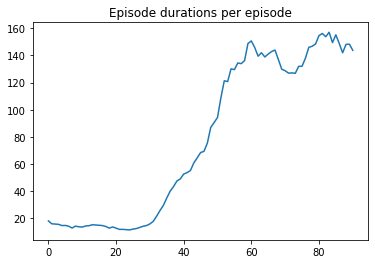

In [27]:
# And see the results
def smooth(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

plt.plot(smooth(episode_durations, 10))
plt.title('Episode durations per episode')


---

## 3. Policy Gradient (8 points)

So we have spent a lot of time working on *value based* methods. We will now switch to *policy based* methods, i.e. learn a policy directly rather than learn a value function from which the policy follows. Mention two advantages of using a policy based method.

- Policy based methods learn action specific probabilities, which is an advantage over value based methods, as the latter only allows the introduction of an $\epsilon$ or plain greedy policy. This attributes to acting randomly or greedy. Policy based methods on the other hand are more flexible and therefore easen the trade-off between exploration and exploitation.

- Policy based methods allow to take advantage of prior knowledge in the form of policy parametrization. This is helpful, if knowledge about a possible optimal policy exists, which then easens the estimation, as it can be improved directly. 





### 3.1 Policy Network

In order to do so, we will implement a Policy network. Although in general this does not have to be the case, we will use an architecture very similar to the Q-network (two layers with ReLU activation for the hidden layer). Since we have discrete actions, our model will output one value per action, where each value represents the (normalized!) log-probability of selecting that action. *Use the (log-)softmax activation function.*

In [28]:
class PolicyNetwork(nn.Module):
    
    def __init__(self, num_hidden=128):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(4, num_hidden)
        self.l2 = nn.Linear(num_hidden, 2)

    def forward(self, x):
            x = self.l2((torch.relu(self.l1(x))))
            x = F.log_softmax(x, dim=x.ndim - 1)
            return x

In [29]:
# Let's instantiate and test if it works
num_hidden = 128
torch.manual_seed(1234)
model = PolicyNetwork(num_hidden)

x = torch.rand(10, 4)

log_p = model(x)

# Does the outcome make sense?
print(log_p.exp())


tensor([[0.4578, 0.5422],
        [0.4657, 0.5343],
        [0.4563, 0.5437],
        [0.4634, 0.5366],
        [0.4564, 0.5436],
        [0.4725, 0.5275],
        [0.4769, 0.5231],
        [0.4834, 0.5166],
        [0.4797, 0.5203],
        [0.4618, 0.5382]], grad_fn=<ExpBackward>)


### 3.2 Monte Carlo REINFORCE

Now we will implement the *Monte Carlo* policy gradient algorithm. Remember from lab 1 that this means that we will estimate returns for states by sample episodes. Compared to DQN, this means that we do *not* perform an update step at every environment step, but only at the end of each episode. This means that we should generate an episode of data, compute the REINFORCE loss (which requires computing the returns) and then perform a gradient step.

To help you, we already implemented a few functions that you can (but do not have to) use.

* You can use `torch.multinomial` to sample from a categorical distribution.
* The REINFORCE loss is defined as $- \sum_t \log \pi_\theta(a_t|s_t) G_t$, which means that you should compute the (discounted) return $G_t$ for all $t$. Make sure that you do this in **linear time**, otherwise your algorithm will be very slow! Note the - (minus) since you want to maximize return while you want to minimize the loss.
* Importantly, you should **normalize the returns** (not the rewards!, e.g. subtract mean and divide by standard deviation within the episode) before computing the loss, or your estimator will have very high variance.

In [30]:
def select_action(model, state):
    # Samples an action according to the probability distribution induced by the model
    # Also returns the log_probability
    log_p = model(torch.FloatTensor(state))
    action = torch.multinomial(log_p.exp(), 1).item()
    
    return action, log_p[action]

def run_episode(env, model):
    # save episode
    episode = []
    # get initial state
    s = env.reset()
    # termination condition
    done = False
    
    while not done:
        # get action and log_p
        a, log_p = select_action(model, s)
        # take action and get next state, terminal condition
        s_next, r, done, _ = env.step(a)
        # append rewards and log_p as tuple to episode list
        episode.append((r, log_p))
        # approach next state if not terminal
        s = s_next
    
    return episode

def compute_reinforce_loss(episode, discount_factor):
    # Compute the reinforce loss
    # Make sure that your function runs in LINEAR TIME
    # Don't forget to normalize your RETURNS (not rewards)
    # Note that the rewards/returns should be maximized 
    # while the loss should be minimized so you need a - somewhere
    
    # get log_ps out of episode list 
    _, log_ps = zip(*episode)

    # initialize   
    log_ps = torch.stack(log_ps)
    returns = []
    tmp_return = 0.0
    
    # get return by reversely iterating through episodes 
    for r, _ in reversed(episode):
        # new return is reward + discount*previous return
        tmp_return = r + discount_factor * tmp_return
        returns.append(tmp_return)
                       
    # reverse to correct order
    returns = torch.FloatTensor(returns[::-1])
    # normalize returns
    returns = (returns - returns.mean())/ returns.std()
    
    return - torch.sum(returns * log_ps)
    
    
def run_episodes_policy_gradient(model, env, num_episodes, discount_factor, learn_rate):
    
    optimizer = optim.Adam(model.parameters(), learn_rate)
    
    episode_durations = []
    for i in range(num_episodes):
        
        episode = run_episode(env, model)
        loss = compute_reinforce_loss(episode, discount_factor)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                           
        if i % 10 == 0:
            print("{2} Episode {0} finished after {1} steps"
                  .format(i, len(episode), '\033[92m' if len(episode) >= 195 else '\033[99m'))
        episode_durations.append(len(episode))

    return episode_durations

 Episode 0 finished after 19 steps
 Episode 10 finished after 17 steps
 Episode 20 finished after 27 steps
 Episode 30 finished after 34 steps
 Episode 40 finished after 200 steps
 Episode 50 finished after 71 steps
 Episode 60 finished after 57 steps
 Episode 70 finished after 33 steps
 Episode 80 finished after 41 steps
 Episode 90 finished after 56 steps
 Episode 100 finished after 132 steps
 Episode 110 finished after 35 steps
 Episode 120 finished after 66 steps
 Episode 130 finished after 38 steps
 Episode 140 finished after 73 steps
 Episode 150 finished after 140 steps
 Episode 160 finished after 200 steps
 Episode 170 finished after 200 steps
 Episode 180 finished after 200 steps
 Episode 190 finished after 200 steps
 Episode 200 finished after 200 steps
 Episode 210 finished after 200 steps
 Episode 220 finished after 200 steps
 Episode 230 finished after 100 steps
 Episode 240 finished after 70 steps
 Episode 250 finished after 41 steps
 Episode 260 finished after 53 steps
 

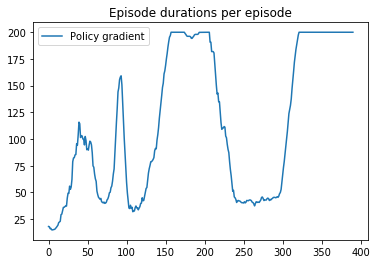

In [31]:
# Feel free to play around with the parameters!
num_episodes = 400
discount_factor = 0.99
learn_rate = 0.01
seed = 42
random.seed(seed)
torch.manual_seed(seed)
env.seed(seed)

model = PolicyNetwork(num_hidden)

episode_durations_policy_gradient = run_episodes_policy_gradient(
    model, env, num_episodes, discount_factor, learn_rate)

plt.plot(smooth(episode_durations_policy_gradient, 10))
plt.title('Episode durations per episode')
plt.legend(['Policy gradient'])

## 4. Deep Reinforcement Learning (5 bonus points)
Note that so far we used the state variables as input. However, the true power of Deep Learning is that we can directly learn from raw inputs, e.g. we can learn to balance the cart pole *by just looking at the screen*. This probably means that you need a deep(er) (convolutional) network, as well as tweaking some parameters, running for more iterations (perhaps on GPU) and do other tricks to stabilize learning. Can you get this to work? This will earn you bonus points!

Hints:
* You may want to use [Google Colab](https://colab.research.google.com/) such that you can benefit from GPU acceleration.
* Even if you don't use Colab, save the weights of your final model and load it in the code here (see example below). Hand in the model file with the .ipynb in a .zip. We likely won't be able to run your training code during grading!
* Preprocessing is already done for you, and the observation is the difference between two consequtive frames such that the model can 'see' (angular) speed from a single image. Now do you see why we (sometimes) use the word observation (and not state)?

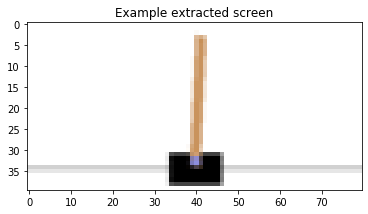

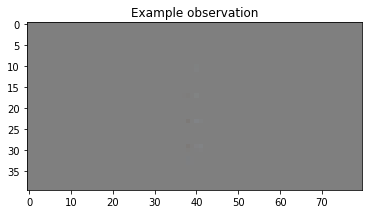

In [32]:
import torchvision.transforms as T
from PIL import Image


resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.ToTensor()])

class CartPoleRawEnv(gym.Env):
    
    def __init__(self, *args, **kwargs):
        self._env = gym.make('CartPole-v0', *args, **kwargs)  #.unwrapped
        self.action_space = self._env.action_space
        screen_height, screen_width = 40, 80  # TODO
        self.observation_space = gym.spaces.Box(
            low=0, high=255, 
            shape=(screen_height, screen_width, 3), dtype=np.uint8)
    
    def seed(self, seed=None):
        return self._env.seed(seed)
    
    def reset(self):
        s = self._env.reset()
        self.prev_screen = self.screen = self.get_screen()
        return self._get_observation()
    
    def step(self, action):
        s, r, done, info = self._env.step(action)
        self.prev_screen = self.screen
        self.screen = self.get_screen()
        return self._get_observation(), r, done, info
    
    def _get_observation(self):
        return self.screen - self.prev_screen
    
    def _get_cart_location(self, screen_width):
        _env = self._env.unwrapped
        world_width = _env.x_threshold * 2
        scale = screen_width / world_width
        return int(_env.state[0] * scale + screen_width / 2.0)  # MIDDLE OF CART

    def get_screen(self):
        screen = self._env.unwrapped.render(mode='rgb_array').transpose(
            (2, 0, 1))  # transpose into torch order (CHW)
        # Strip off the top and bottom of the screen
        _, screen_height, screen_width = screen.shape
        screen = screen[:, screen_height * 4 // 10:screen_height * 8 // 10]
        view_width = screen_height * 8 // 10
        cart_location = self._get_cart_location(screen_width)
        if cart_location < view_width // 2:
            slice_range = slice(view_width)
        elif cart_location > (screen_width - view_width // 2):
            slice_range = slice(-view_width, None)
        else:
            slice_range = slice(cart_location - view_width // 2,
                                cart_location + view_width // 2)
        # Strip off the edges, so that we have a square image centered on a cart
        screen = screen[:, :, slice_range]
        # Convert to float, rescare, convert to torch tensor
        # (this doesn't require a copy)
        screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
        screen = torch.from_numpy(screen)
        # Resize, and add a batch dimension (BCHW)
        #return screen.unsqueeze(0).to(device)
        return resize(screen).unsqueeze(0)
    
    def close(self):
        return self._env.close()

raw_env = CartPoleRawEnv()
s = raw_env.reset()

# 
s, r, done, _ = raw_env.step(env.action_space.sample())

raw_env.reset()
plt.figure()
plt.imshow(raw_env.get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(),
           interpolation='none')
plt.title('Example extracted screen')
plt.show()

# Observations are (-1, 1) while we need to plot (0, 1) so show (rgb + 1) / 2
plt.figure()
plt.imshow((s.cpu().squeeze(0).permute(1, 2, 0).numpy() + 1) / 2,
           interpolation='none')
plt.title('Example observation')
plt.show()
raw_env.close()

In [33]:
# Maybe you should make it a bit deeper?
class DeepPolicy(nn.Module):
    def __init__(self):
        nn.Module.__init__(self)
        self.l1 = nn.Linear(40 * 80 * 3, 2)

    def forward(self, x):
        # Flatten
        return F.log_softmax(self.l1(x.view(x.size(0), -1)), -1)
    
policy = DeepPolicy()
filename = 'weights.pt'

if os.path.isfile(filename):
    print(f"Loading weights from {filename}")
    weights = torch.load(filename, map_location='cpu')
    
    policy.load_state_dict(weights['policy'])
    
else:
    # Train
    
    ### TODO some training here, maybe? Or run this on a different machine?
    torch.manual_seed(42)
    
    print(f"Saving weights to {filename}")
    torch.save({
        # You can add more here if you need, e.g. critic
        'policy': policy.state_dict()  # Always save weights rather than objects
    },
    filename)
    
def bonus_get_action(x):
    return policy(x).exp().multinomial(1)[:, 0]

Loading weights from weights.pt


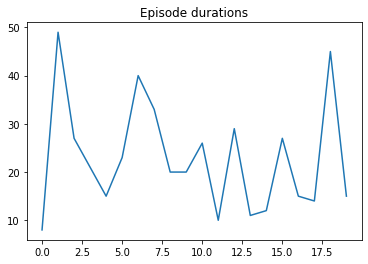

In [34]:
seed = 42
episode_durations = []
for i in range(20):  # Not too many since it may take forever to render
    test_env = CartPoleRawEnv()
    test_env.seed(seed + i)
    state = test_env.reset()
    done = False
    steps = 0
    while not done:
        steps += 1
        with torch.no_grad():
            action = bonus_get_action(state).item()
        state, reward, done, _ = test_env.step(action)
    episode_durations.append(steps)
    test_env.close()
    
plt.plot(episode_durations)
plt.title('Episode durations')
plt.show()
